  # Imports

In [175]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import roc_curve, auc
from rdkit import Chem
from matplotlib.cm import viridis
from matplotlib.colors import Normalize


  # Graphing Settings

In [176]:
matplotlib.rcdefaults()
sns.set_style("darkgrid")
plt.rcParams["figure.dpi"] = 100

pd.set_option("display.max_columns", None)


  # Papermill Parameters

In [177]:
# title suffix
title_suffix = "S1PR1"

# Files we are processing
file_path_sdf_active = "./S1PR1/docking/S1PR1_active_docking_lib_sorted.sdf"
file_path_sdf_decoy = "./S1PR1/docking/S1PR1_decoy_docking_lib_sorted.sdf"

file_path_strain_active = "./S1PR1/freeform_strain/S1PR1_active_f.csv"
file_path_strain_decoy = "./S1PR1/freeform_strain/S1PR1_decoy_f.csv"

  # Data Processing

In [178]:
def sdf_to_df(args):
    """
    Load molecules and their properties from an SDF file into a DataFrame.

    Example usage: df=sdf_to_df(("./ADRB1/docking/ADRB1_active_docking_lib.sdf", "active"))

    Note that this function was originally intended to be used with the `multiprocessing` module, so the arguments are passed as a tuple.

    Will likely be updated later.

    """
    file, active_status = args  # Unpack the tuple of arguments

    # Create a molecule supplier
    mol_supplier = Chem.MultithreadedSDMolSupplier(file, numWriterThreads=8)

    # Load the molecules and their properties into a list
    molecules = []
    first_mol = True
    for mol in mol_supplier:
        if mol is not None:
            if first_mol:
                # Get properties as dictionary only for the first molecule
                props = mol.GetPropsAsDict()
                keys = props.keys()
                first_mol = False
            else:
                # For the rest of the molecules, get properties directly
                props = {key: mol.GetProp(key) for key in keys if mol.HasProp(key)}

            props["Title"] = mol.GetProp("_Name")
            props["Mol"] = mol
            props["Activity"] = 1 if active_status == "active" else 0
            molecules.append(props)

    # Convert the list into a DataFrame
    df = pd.DataFrame(molecules)

    # Reorder the DataFrame columns
    cols = ["Title", "Mol", "Activity"] + [
        col for col in df.columns if col not in ["Title", "Mol", "Activity"]
    ]
    df = df[cols]
    df = df.rename(columns={"Title": "Molecule_Name"})

    # Convert 'r_i_docking_score' to numeric, coercing errors to NaN
    df["r_i_docking_score"] = pd.to_numeric(df["r_i_docking_score"], errors="coerce")

    # Print 'Molecule_Name' and 'r_i_docking_score' for entries that could not be converted
    non_convertible_entries = df[df["r_i_docking_score"].isna()]
    for _, row in non_convertible_entries.iterrows():
        print(
            f"Molecule_Name: {row['Molecule_Name']}, r_i_docking_score: {row['r_i_docking_score']}"
        )

    # Drop rows with non-convertible 'r_i_docking_score'
    df = df.dropna(subset=["r_i_docking_score"])

    # Convert 'r_i_docking_score' to int64
    df["r_i_docking_score"] = df["r_i_docking_score"].astype("float64")

    return df



In [179]:
active_sdf = sdf_to_df((file_path_sdf_active, "active"))
decoy_sdf = sdf_to_df((file_path_sdf_decoy, "inactive"))


In [180]:
duplicates_actives = active_sdf["Molecule_Name"].duplicated()
print("Duplicates in active_sdf:", any(duplicates_actives))

duplicates_decoys = decoy_sdf["Molecule_Name"].duplicated()
print("Duplicates in decoy_sdf:", any(duplicates_decoys))

Duplicates in active_sdf: False
Duplicates in decoy_sdf: False


In [181]:
def concat_freeform_csv(file_list):
    """
    Concatenates multiple strain CSV files into a single dataframe.

    Args:
        file_list (list): A list of file paths to the CSV files.

    Returns:
        pandas.DataFrame: The concatenated dataframe.

    """
    # List to hold dataframes
    df_list = []

    # Loop over each file in the list
    for file in file_list:
        # Import the CSV file as a df and rename the 'ID' column to 'Molecule_Name'
        df = pd.read_csv(file).rename(columns={"ID": "Molecule_Name"})
        df_list.append(df)

    # Concatenate all dataframes in the list
    final_df = pd.concat(df_list, ignore_index=True)

    return final_df

In [182]:
active_strain = concat_freeform_csv([file_path_strain_active])
decoy_strain = concat_freeform_csv([file_path_strain_decoy])

In [183]:
def clean_freeform_dataframe(df, column_name="Strain (kcal/mol)"):
    initial_count = len(df)
    nan_count = df[column_name].isna().sum()
    df = df.dropna(subset=[column_name])
    negative_count = (df[column_name] < 0).sum()
    df = df[df[column_name] >= 0]
    print(f"Dropped {nan_count} rows due to NaN values.")
    print(f"Dropped {negative_count} rows due to negative values in '{column_name}'.")
    final_count = len(df)
    print(f"Initially {initial_count} rows, now {final_count} rows.")
    return df


# Example usage:
# active_strain = clean_dataframe(active_strain, 'Strain (kcal/mol)')
# decoy_strain = clean_dataframe(decoy_strain, 'Strain (kcal/mol)')


In [184]:
active_strain = clean_freeform_dataframe(active_strain)

Dropped 0 rows due to NaN values.
Dropped 0 rows due to negative values in 'Strain (kcal/mol)'.
Initially 215 rows, now 215 rows.


In [185]:
decoy_strain = clean_freeform_dataframe(decoy_strain)

Dropped 0 rows due to NaN values.
Dropped 0 rows due to negative values in 'Strain (kcal/mol)'.
Initially 8919 rows, now 8919 rows.


In [186]:
duplicates_actives = active_strain["Molecule_Name"].duplicated()
print("Duplicates in active_strain:", any(duplicates_actives))

duplicates_decoys = decoy_strain["Molecule_Name"].duplicated()
print("Duplicates in decoy_strain:", any(duplicates_decoys))

Duplicates in active_strain: False
Duplicates in decoy_strain: False


In [187]:
active_data = pd.merge(active_sdf, active_strain, on="Molecule_Name")
decoy_data = pd.merge(decoy_sdf, decoy_strain, on="Molecule_Name")

In [188]:
pre_merge = {
    "active_sdf": active_sdf,
    "active_strain": active_strain,
    "decoy_sdf": decoy_sdf,
    "decoy_strain": decoy_strain,
}

print(
    "Dataframe shapes before the merge of [active_sdf + active_strain] to [active_data] and [decoy_sdf + decoy_strain] to [decoy_data]:\n"
)
for name, df in pre_merge.items():
    print(f"{name}: {df.shape}")


Dataframe shapes before the merge of [active_sdf + active_strain] to [active_data] and [decoy_sdf + decoy_strain] to [decoy_data]:

active_sdf: (215, 33)
active_strain: (215, 3)
decoy_sdf: (8924, 33)
decoy_strain: (8919, 3)


In [189]:
post_merge = {"active_data": active_data, "decoy_data": decoy_data}

print("Dataframe shapes after merge to active_data and decoy_data:")
for name, df in post_merge.items():
    print(f"{name}: {df.shape}")



Dataframe shapes after merge to active_data and decoy_data:
active_data: (215, 35)
decoy_data: (8919, 35)


In [190]:
all_data = pd.concat([active_data, decoy_data])

print(
    "Dataframe shape after concat of active_data and decoy_data to all_data\n",
    all_data.shape,
    "\n",
)

print("all_data should be addition of the inputs")


Dataframe shape after concat of active_data and decoy_data to all_data
 (9134, 35) 

all_data should be addition of the inputs


  # Baseline

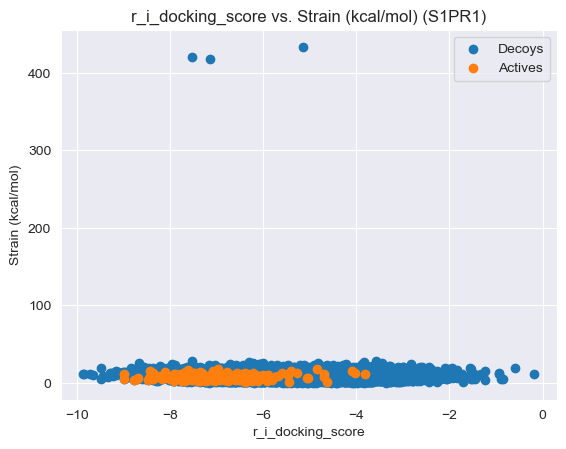

In [191]:
plt.scatter(all_data["r_i_docking_score"], all_data["Strain (kcal/mol)"])
actives_all_data = all_data[all_data["Activity"] == 1]
plt.scatter(
    actives_all_data["r_i_docking_score"], actives_all_data["Strain (kcal/mol)"]
)
plt.title(f"r_i_docking_score vs. Strain (kcal/mol) ({title_suffix})")
plt.xlabel("r_i_docking_score")
plt.ylabel("Strain (kcal/mol)")
plt.legend(["Decoys", "Actives"])
plt.show()

In [192]:
def plot_density_docking(df, title_suffix):
    # Hardcoded column names
    activity_col = "Activity"
    score_col = "r_i_docking_score"

    # Create a density plot for the score of active and inactive molecules
    sns.kdeplot(df.loc[df[activity_col] == 0, score_col], label="Inactive", fill=True)
    sns.kdeplot(df.loc[df[activity_col] == 1, score_col], label="Active", fill=True)

    # Add title and labels
    plt.title(
        f"Density Plot of Docking Score for Active and Decoy Molecules ({title_suffix})"
    )
    plt.xlabel("Docking Score")
    plt.ylabel("Density")
    plt.legend(loc="best")

    # Show the plot
    plt.show()



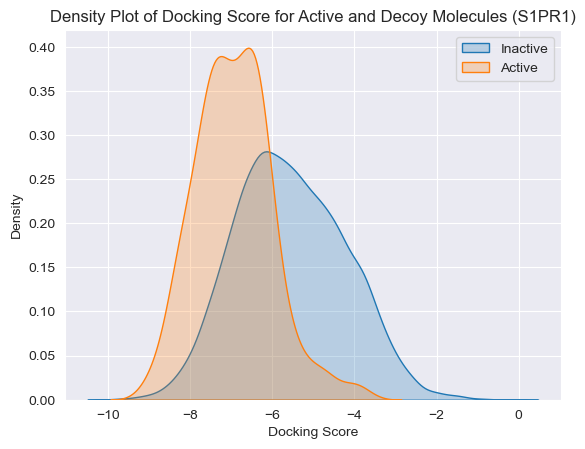

In [193]:
plot_density_docking(all_data, title_suffix)



In [194]:
def plot_histogram_dscore(df, title_suffix):
    # Hardcoded column names
    activity_col = "Activity"
    score_col = "r_i_docking_score"

    plt.hist(
        df.loc[df[activity_col] == 0, score_col],
        bins=50,
        label="Inactive",
        alpha=0.5,
        density=True,
    )
    plt.hist(
        df.loc[df[activity_col] == 1, score_col],
        bins=50,
        label="Active",
        alpha=0.5,
        density=True,
    )

    # Add title and labels
    plt.title(
        f"Density Histogram of Docking Score for Active and Decoy Molecules ({title_suffix})"
    )
    plt.xlabel("Docking Score")
    plt.ylabel("Density")
    plt.legend(loc="best")

    # Show the plot
    plt.show()



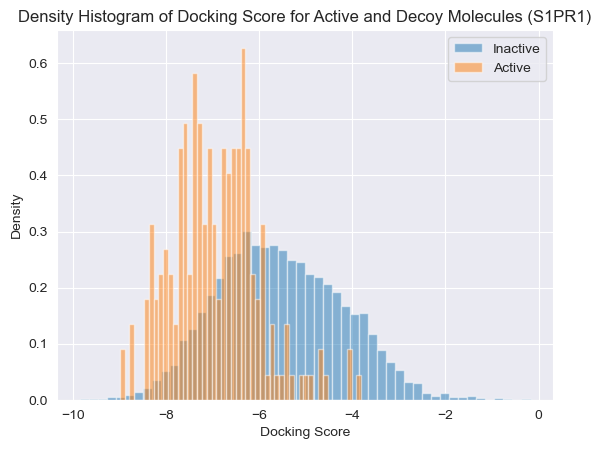

In [195]:
plot_histogram_dscore(all_data, title_suffix)



In [196]:
def plot_density_strain(df, title_suffix):
    # Hardcoded column names
    activity_col = "Activity"
    score_col = "Strain (kcal/mol)"

    # Create a density plot for the score of active and inactive molecules
    sns.kdeplot(df.loc[df[activity_col] == 0, score_col], label="Inactive", fill=True)
    sns.kdeplot(df.loc[df[activity_col] == 1, score_col], label="Active", fill=True)

    # Add title and labels
    plt.title(
        f"Density Plot of Strain Energy for Active and Decoy Molecules ({title_suffix})"
    )
    plt.xlabel("Total Strain Energy")
    plt.ylabel("Density")
    plt.legend(loc="best")

    # Show the plot
    plt.show()



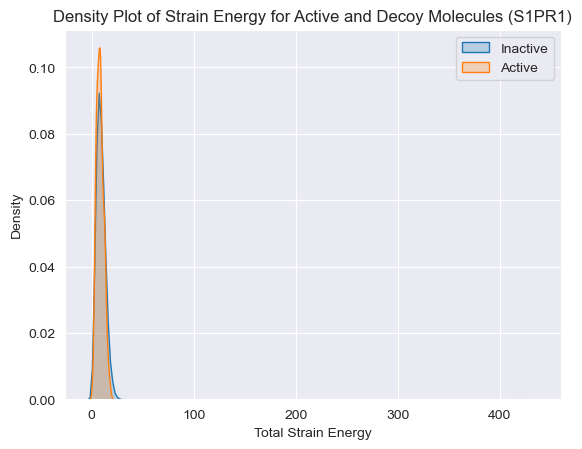

In [197]:
plot_density_strain(all_data, title_suffix)



In [198]:
def plot_histogram_strain(df, title_suffix):
    # Hardcoded column names
    activity_col = "Activity"
    score_col = "Strain (kcal/mol)"

    plt.hist(
        df.loc[df[activity_col] == 0, score_col],
        bins=50,
        label="Inactive",
        alpha=0.5,
        density=True,
    )
    plt.hist(
        df.loc[df[activity_col] == 1, score_col],
        bins=50,
        label="Active",
        alpha=0.5,
        density=True,
    )

    # Add title and labels
    plt.title(
        f"Density Histogram of Strain Energy for Active and Decoy Molecules ({title_suffix})"
    )
    plt.xlabel("Total Strain Energy")
    plt.ylabel("Density")
    plt.legend(loc="best")

    # Show the plot
    plt.show()


# The density parameter is set to True, which means the histogram will show the density (the number of samples in a bin divided by the size of the bin) instead of the raw count.

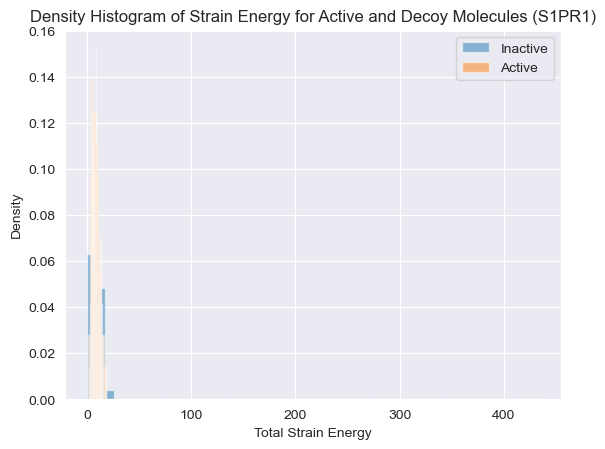

In [199]:
plot_histogram_strain(all_data, title_suffix)


  # Enrichment by Strain Thresholds

In [200]:
total_e_thresholds = [
    None,
    4,
    4.5,
    5.0,
    5.5,
    6.0,
    7.0,
    7.5,
    8.0,
]  # strain energy thresholds



In [201]:
def calculate_enrichment_parameters(df):
    """
    Calculates parameters we will need for Enrichment Plots

    Parameters:
    df (pandas.DataFrame): The dataframe to calculate the logAUC for.

    Returns:
    pandas.DataFrame: The dataframe with the logAUC calculated.
    """
    # Sort the subset by 'r_i_docking_score' in ascending order

    df = df.copy()

    df.sort_values(by="r_i_docking_score", inplace=True)

    # Reset the index so that we are ranking by the docking score
    df.reset_index(drop=True, inplace=True)

    # Adjusting the index to start from 1
    df.index += 1

    # Calculate the cumulative sum of active compounds
    df["Cumulative_Actives"] = df["Activity"].cumsum()

    # Calculate the Total Actives
    df["Total_Actives"] = df["Activity"].sum()

    # Calculate the fraction of identified actives at each row
    df["Fraction_Actives"] = df["Cumulative_Actives"] / df["Total_Actives"]

    # Calculate the percentage of compounds screened at each row
    df["Percentage_Screened"] = df.index / len(df)

    return df



In [202]:
all_data = calculate_enrichment_parameters(all_data)



In [203]:
def enrichment_metrics_by_strain(df, total_e_threshold=None):

    if total_e_threshold is not None:
        df = df[df["Strain (kcal/mol)"] <= total_e_threshold]

    df = calculate_enrichment_parameters(df).copy()

    closest_to_one_percent = df.iloc[
        (df["Percentage_Screened"] - 0.01).abs().argsort()[:1]
    ]

    ef1 = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent["Total_Actives"].values[0]
    ) * 100

    closest_to_five_percent = df.iloc[
        (df["Percentage_Screened"] - 0.05).abs().argsort()[:1]
    ]
    ef5 = (
        closest_to_five_percent["Cumulative_Actives"].values[0]
        / closest_to_five_percent["Total_Actives"].values[0]
    ) * 100

    return ef1, ef5

In [290]:
def bar_plot_enrichment_by_strain(data, thresholds, title_suffix):
    # Calculate enrichment for each threshold
    ef1s, ef5s = zip(
        *[enrichment_metrics_by_strain(data, total_e_threshold=t) for t in thresholds]
    )

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else "No Cutoff" for t in thresholds]

    # Create an array with the positions of each bar on the x axis
    x = np.arange(len(x_labels))

    # Set the width of the bars
    bar_width = 0.35

    plt.bar(x - bar_width / 2, ef1s, bar_width, label="EF1%")
    plt.bar(x + bar_width / 2, ef5s, bar_width, label="EF5%")
    plt.title(f"Enrichment Factors by Freeform Strain Energy Cutoff ({title_suffix})")
    plt.xlabel("Strain Energy Cutoff")
    plt.ylabel("Enrichment Factor (%)")
    plt.xticks(x, x_labels)  # Set the position and labels of the xticks
    plt.legend()
    plt.show()



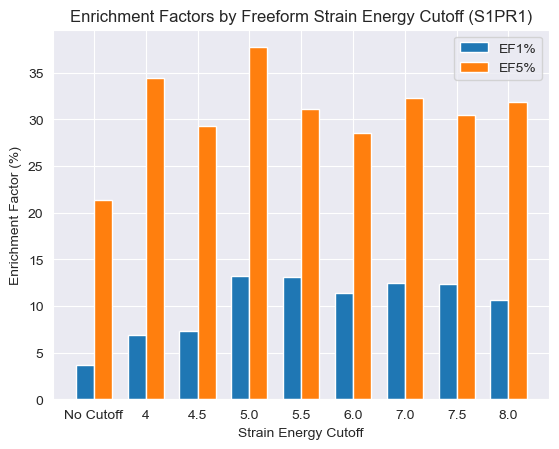

In [291]:
bar_plot_enrichment_by_strain(all_data, total_e_thresholds, title_suffix)



In [292]:
def bar_plot_delta_enrichment_by_strain(data, thresholds, title_suffix):
    # Calculate enrichment for each threshold
    ef1s, ef5s = zip(
        *[enrichment_metrics_by_strain(data, total_e_threshold=t) for t in thresholds]
    )

    # Calculate differences in enrichment metrics
    ef1s_diff = [ef - ef1s[0] for ef in ef1s]
    ef5s_diff = [ef - ef5s[0] for ef in ef5s]

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else "No Cutoff" for t in thresholds]

    # Create an array with the positions of each bar on the x axis
    x = np.arange(len(x_labels))

    # Set the width of the bars
    bar_width = 0.35

    plt.bar(x - bar_width / 2, ef1s_diff, bar_width, label="EF1% Difference")
    plt.bar(x + bar_width / 2, ef5s_diff, bar_width, label="EF5% Difference")
    plt.title(
        f"Difference in Enrichment Factors by Freeform Strain Energy Cutoff ({title_suffix})"
    )
    plt.xlabel("Strain Energy Cutoff")
    plt.ylabel("Difference in Enrichment Factor (%)")
    plt.xticks(x, x_labels)  # Set the position and labels of the xticks
    plt.legend()
    plt.show()



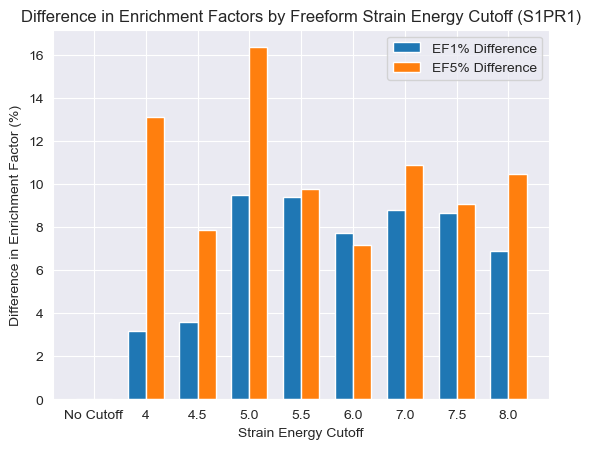

In [293]:
bar_plot_delta_enrichment_by_strain(all_data, total_e_thresholds, title_suffix)



/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_53762/755329442.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(


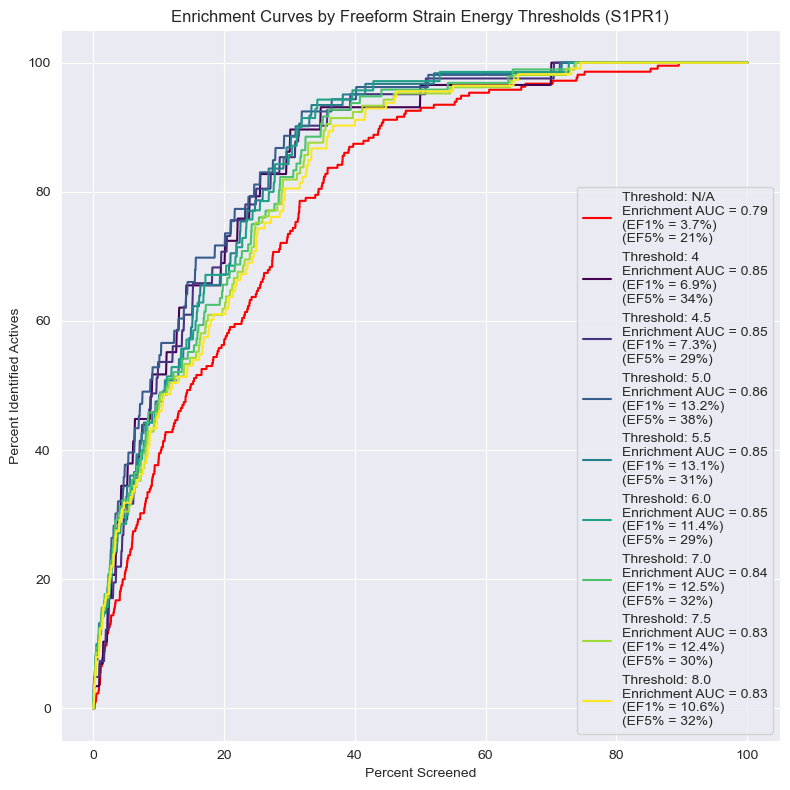

In [294]:
def plot_enrichment_curve_by_strain(df, total_e_threshold=None, ax=None, color="blue"):

    if total_e_threshold is not None:
        df = df[df["Strain (kcal/mol)"] <= total_e_threshold]

    df = calculate_enrichment_parameters(df).copy()

    enrichment_auc = auc(df["Percentage_Screened"], df["Fraction_Actives"])

    closest_to_one_percent = df.iloc[
        (df["Percentage_Screened"] - 0.01).abs().argsort()[:1]
    ]

    ef1 = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent["Total_Actives"].values[0]
    ) * 100

    closest_to_five_percent = df.iloc[
        (df["Percentage_Screened"] - 0.05).abs().argsort()[:1]
    ]
    ef5 = (
        closest_to_five_percent["Cumulative_Actives"].values[0]
        / closest_to_five_percent["Total_Actives"].values[0]
    ) * 100

    # Plot the enrichment curve
    ax.plot(
        df["Percentage_Screened"] * 100,
        df["Fraction_Actives"] * 100,
        label="Threshold: {}\nEnrichment AUC = {:.2f}\n(EF1% = {:.1f}%)\n(EF5% = {:.0f}%)".format(
            total_e_threshold if total_e_threshold is not None else "N/A",
            enrichment_auc,
            ef1,
            ef5,
        ),
        color=color,
    )

    ax.legend()


def plot_enrichment_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # Define a colormap
    cmap = cm.get_cmap(
        "viridis", len(thresholds) - 1
    )  # Subtract 1 because the first color is manually set

    # Plot semi-log ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Filter dataframe based on 'Strain (kcal/mol)' threshold
        df_filtered = data if t is None else data[data["Strain (kcal/mol)"] <= t]

        # Set a distinct color for the first threshold
        color = (
            "red" if t is None else cmap(i - 1)
        )  # Subtract 1 because the first color is manually set

        # Call the function with the filtered data
        plot_enrichment_curve_by_strain(
            df_filtered, total_e_threshold=t, ax=ax, color=color
        )

    ax.set_title(f"Enrichment Curves by Freeform Strain Energy Thresholds ({title_suffix})")
    ax.set_xlabel("Percent Screened")
    ax.set_ylabel("Percent Identified Actives")

    plt.tight_layout()
    plt.show()


plot = plot_enrichment_all_thresholds(all_data, total_e_thresholds, title_suffix)



In [295]:
def write_enrichment_metrics(data, thresholds, title_suffix):
    # Calculate enrichment for each threshold
    ef1s, ef5s = zip(
        *[enrichment_metrics_by_strain(data, total_e_threshold=t) for t in thresholds]
    )

    # Calculate the difference in enrichment metrics
    ef1s_diff = [ef - ef1s[0] for ef in ef1s]
    ef5s_diff = [ef - ef5s[0] for ef in ef5s]

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else "No Cutoff" for t in thresholds]

    # Create a dataframe to hold the data
    df = pd.DataFrame(
        {
            "Protein": title_suffix,
            "Strain Energy Cutoff": x_labels,
            "EF1%": ef1s,
            "EF5%": ef5s,
            "deltaEF1%": ef1s_diff,
            "deltaEF5%": ef5s_diff,
        }
    )

    # Create a directory to store the freeform CSV files if it doesn't exist
    dir_name = "./papermill/freeform_csv"
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

    print(
        f"Writing CSV to ./papermill/freeform_csv/strain_enrichment_metrics_{title_suffix}.csv"
    )
    df.to_csv(
        f"./papermill/freeform_csv/strain_enrichment_metrics_{title_suffix}.csv",
        index=False,
    )
    display(df)
    print("CSV writing complete.")

In [296]:
write_enrichment_metrics(all_data, total_e_thresholds, title_suffix)


Writing CSV to ./papermill/freeform_csv/strain_enrichment_metrics_S1PR1.csv


,Protein,Strain Energy Cutoff,EF1%,EF5%,deltaEF1%,deltaEF5%
0,S1PR1,No Cutoff,3.720930,21.395349,0.000000,0.000000
1,S1PR1,4,6.896552,34.482759,3.175621,13.087410
2,S1PR1,4.5,7.317073,29.268293,3.596143,7.872944
3,S1PR1,5.0,13.207547,37.735849,9.486617,16.340500
4,S1PR1,5.5,13.114754,31.147541,9.393824,9.752192
5,S1PR1,6.0,11.428571,28.571429,7.707641,7.176080
6,S1PR1,7.0,12.500000,32.291667,8.779070,10.896318
7,S1PR1,7.5,12.380952,30.476190,8.660022,9.080842
8,S1PR1,8.0,10.619469,31.858407,6.898539,10.463058


CSV writing complete.


  # Linear Log ROC AUC by Strain Threshold

In [297]:
def logauc_by_strain(df, a=1e-3, total_e_threshold=None):
    # Filter dataframe based on 'Strain (kcal/mol)' threshold if provided
    if total_e_threshold is not None:
        df = df[df["Strain (kcal/mol)"] <= total_e_threshold]

    # Invert scores since lower scores indicate positive class
    y_scores_inverted = -df["r_i_docking_score"]

    # Calculate FPR, TPR, and thresholds using sklearn
    fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

    # Select the thresholds that result in FPR >= a for log scale plotting
    valid_indices = np.where(fpr >= a)
    fpr_valid = fpr[valid_indices]
    tpr_valid = tpr[valid_indices]

    # Calculate log of FPR for valid indices
    log_fpr_valid = np.log10(fpr_valid)

    # Calculate the AUC for the valid range
    linlog_auc = auc(log_fpr_valid, tpr_valid)

    ### NOTE TIMES 10 NOTE ###
    log_auc = (linlog_auc / -np.log10(a)) * 10

    return log_auc



In [299]:
def plot_log_aucs(data, thresholds, title_suffix):
    # Calculate log_auc for each threshold and plot
    log_aucs = [logauc_by_strain(data, total_e_threshold=t) for t in thresholds]

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else "No Cutoff" for t in thresholds]

    plt.bar(range(len(thresholds)), log_aucs, tick_label=x_labels)
    plt.title(f"Linear Log10 AUC by Freeform Strain Energy Cutoff ({title_suffix})")
    plt.xlabel("Strain Energy Cutoff")
    plt.ylabel("Linear Log10 AUC (x10)")
    plt.show()



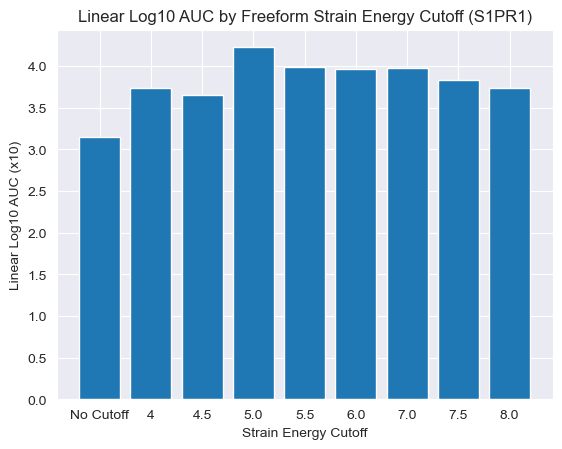

In [300]:
plot_log_aucs(all_data, total_e_thresholds, title_suffix)



In [303]:
def plot_delta_log_aucs(data, thresholds, title_suffix):
    # Calculate log_auc for 'None' threshold
    none_log_auc = logauc_by_strain(data, total_e_threshold=None)

    # Calculate delta log_auc for each threshold and plot
    delta_log_aucs = [
        logauc_by_strain(data, total_e_threshold=t) - none_log_auc for t in thresholds
    ]

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else "No Cutoff" for t in thresholds]

    plt.bar(range(len(thresholds)), delta_log_aucs, tick_label=x_labels)
    plt.title(f"Delta Linear Log10 AUC by Freeform Strain Energy Cutoff ({title_suffix})")
    plt.xlabel("Strain Energy Cutoff")
    plt.ylabel("Delta Linear Log10 AUC (x10)")
    plt.show()



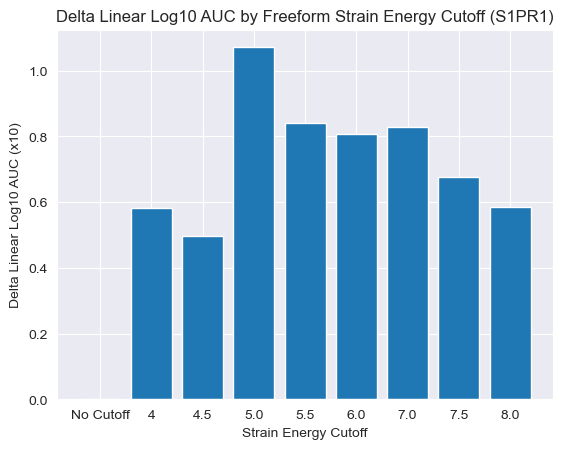

In [304]:
plot_delta_log_aucs(all_data, total_e_thresholds, title_suffix)



In [305]:
def write_log_aucs_delta_auc(data, thresholds, title_suffix):
    # Calculate log_auc for each threshold
    log_aucs = [logauc_by_strain(data, total_e_threshold=t) for t in thresholds]

    delta_log_aucs = [0] + [log_aucs[i] - log_aucs[0] for i in range(1, len(log_aucs))]

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else "No Cutoff" for t in thresholds]

    # Create a dataframe to hold the data
    df = pd.DataFrame(
        {
            "Protein": title_suffix,
            "Strain Energy Cutoff": x_labels,
            "Linear Log10 AUC (x10)": log_aucs,
            "Delta Linear Log10 AUC (x10)": delta_log_aucs,
        }
    )

    # Write the dataframe to a CSV file
    df.to_csv(f"./papermill/freeform_csv/strain_log_aucs_{title_suffix}.csv", index=False)
    display(df)



In [306]:
write_log_aucs_delta_auc(all_data, total_e_thresholds, title_suffix)



,Protein,Strain Energy Cutoff,Linear Log10 AUC (x10),Delta Linear Log10 AUC (x10)
0,S1PR1,No Cutoff,3.154225,0.000000
1,S1PR1,4,3.735036,0.580810
2,S1PR1,4.5,3.651054,0.496828
3,S1PR1,5.0,4.225450,1.071225
4,S1PR1,5.5,3.993972,0.839747
5,S1PR1,6.0,3.960137,0.805912
6,S1PR1,7.0,3.981800,0.827575
7,S1PR1,7.5,3.829732,0.675506
8,S1PR1,8.0,3.739108,0.584883


In [307]:
def plot_semi_log_roc(df, a=1e-3, total_e_threshold=None, ax=None, color="blue"):
    # Filter dataframe based on 'Strain (kcal/mol)' threshold if provided
    if total_e_threshold is not None:
        df = df[df["Strain (kcal/mol)"] <= total_e_threshold]

    # Invert scores since lower scores indicate positive class
    y_scores_inverted = -df["r_i_docking_score"]

    # Calculate FPR, TPR, and thresholds using sklearn
    fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

    # Select the thresholds that result in FPR >= a for log scale plotting
    valid_indices = np.where(fpr >= a)
    fpr_valid = fpr[valid_indices]
    tpr_valid = tpr[valid_indices]

    # Calculate log of FPR for valid indices
    log_fpr_valid = np.log10(fpr_valid)

    # Calculate LogAUC
    log_auc = (auc(log_fpr_valid, tpr_valid) / -np.log10(a)) * 10

    # Count the number of rows with Activity = 1 and the total number of rows
    activity_1_count = df[df["Activity"] == 1].shape[0]
    total_count = df.shape[0]

    # Plot semi-log ROC curve
    ax.plot(
        log_fpr_valid,
        tpr_valid,
        label=f"Threshold: {total_e_threshold if total_e_threshold is not None else 'N/A'}, LogAUC: {log_auc:.2f}, Actives: {activity_1_count}, Total count: {total_count}",
        color=color,
    )
    ax.legend()



In [309]:
def plot_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Define a colormap
    cmap = cm.get_cmap(
        "viridis", len(thresholds) - 1
    )  # Subtract 1 because the first color is manually set

    # Plot semi-log ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Filter dataframe based on 'Strain (kcal/mol)' threshold
        df_filtered = data if t is None else data[data["Strain (kcal/mol)"] <= t]

        # Set a distinct color for the first threshold
        color = (
            "red" if t is None else cmap(i - 1)
        )  # Subtract 1 because the first color is manually set

        # Call the function with the filtered data
        plot_semi_log_roc(df_filtered, total_e_threshold=t, ax=ax, color=color)

    ax.set_title(f"Log10AUC (x10) Freeform Strain Energy Thresholds ({title_suffix})")
    ax.set_xlabel("log(FPR)")
    ax.set_ylabel("TPR")

    plt.tight_layout()
    plt.show()



/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_53762/3212299553.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(


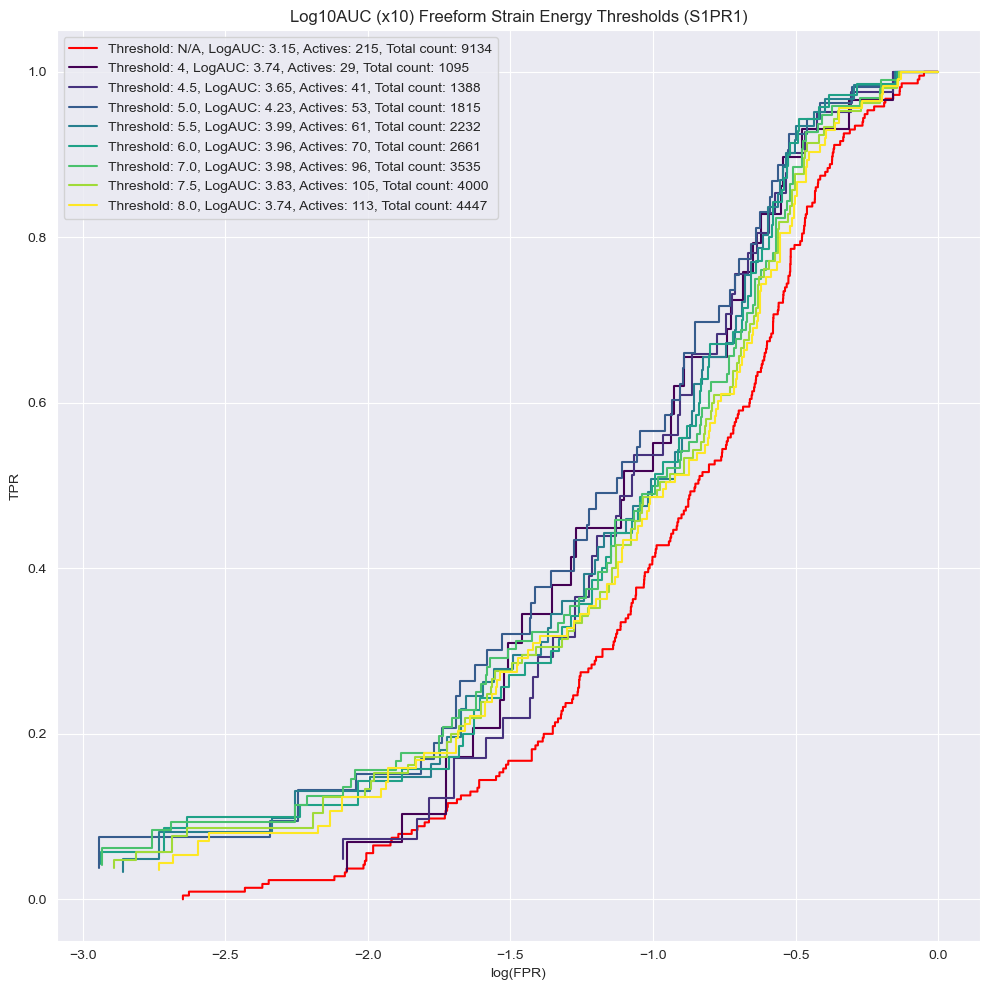

In [310]:
plot = plot_all_thresholds(all_data, total_e_thresholds, title_suffix)


  # ROC AUC by Strain Threshold

In [313]:
def plot_roc_curve_inverted(data, total_e_threshold, ax, title_suffix, color="blue"):
    """
    Plot the ROC curve for the given true labels and inverted scores.

    :param data: The DataFrame containing the data.
    :param total_e_threshold: The threshold for the 'Strain (kcal/mol)' column. If this is not None, the data is filtered to only include rows where 'Strain (kcal/mol)' is less than or equal to this threshold.
    :param ax: The axes object to plot on.
    :param title_suffix: The suffix to add to the title of the plot.
    :param color: The color to use for the ROC curve.
    """
    # Filter the data based on 'Strain (kcal/mol)' threshold
    df = (
        data
        if total_e_threshold is None
        else data[data["Strain (kcal/mol)"] <= total_e_threshold]
    )

    # Get the true labels and scores
    y_true = df["Activity"]
    y_scores = df["r_i_docking_score"]

    # Inverting the scores
    y_scores_inverted = -y_scores

    # Compute the ROC curve and AUC with inverted scores
    fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
    roc_auc = auc(fpr, tpr)

    # Count the number of rows with Activity = 1 and the total number of rows
    activity_1_count = df[df["Activity"] == 1].shape[0]
    total_count = df.shape[0]

    # Plotting the ROC curve
    # ax.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.2f}), Actives: {activity_1_count}, Total Count: {total_count}", color=color)

    # Plotting the ROC curve
    ax.plot(
        fpr,
        tpr,
        lw=2,
        label=f"Threshold: {total_e_threshold if total_e_threshold is not None else 'N/A'}, ROC curve (AUC = {roc_auc:.2f}), Actives: {activity_1_count}, Total Count: {total_count}",
        color=color,
    )

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(
        f"Receiver Operating Characteristic (Inverted Scores) - Freeform ({title_suffix})"
    )



In [314]:
def plot_roc_curves_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Define a colormap
    cmap = cm.get_cmap(
        "viridis", len(thresholds) - 1
    )  # Subtract 1 because the first color is manually set

    # Plot ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Set a distinct color for the first threshold
        color = (
            "red" if t is None else cmap(i - 1)
        )  # Subtract 1 because the first color is manually set

        plot_roc_curve_inverted(
            data, total_e_threshold=t, ax=ax, title_suffix=title_suffix, color=color
        )

    # Plot the random classifier line after all the ROC curves
    ax.plot(
        [0, 1], [0, 1], lw=2, linestyle="--", label="Random Classifier", color="grey"
    )

    ax.legend()

    plt.show()



/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_53762/1947216038.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(


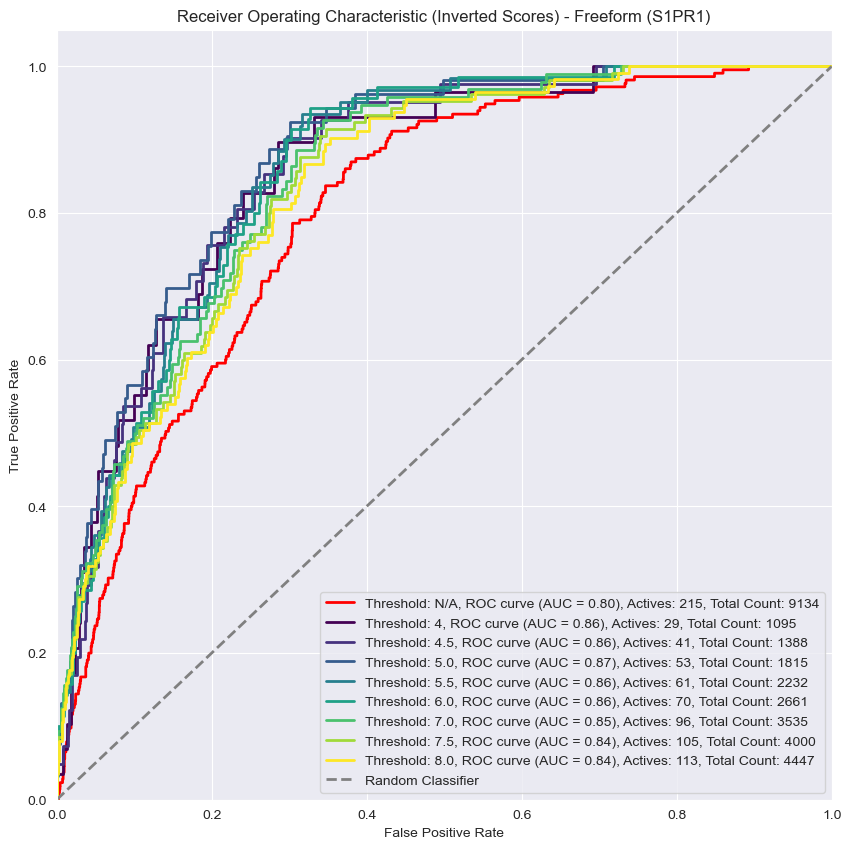

In [315]:
plot_roc_curves_all_thresholds(all_data, total_e_thresholds, title_suffix)



In [318]:
def bar_plot_difference_in_auc_by_strain(data, thresholds, title_suffix):
    # Create a list to hold AUC values
    auc_values = []

    # Loop over each threshold
    for t in thresholds:
        # Filter the data based on 'Strain (kcal/mol)' threshold
        df = data if t is None else data[data["Strain (kcal/mol)"] <= t]

        # Get the true labels and scores
        y_true = df["Activity"]
        y_scores = df["r_i_docking_score"]

        # Inverting the scores
        y_scores_inverted = -y_scores

        # Compute the ROC curve and AUC with inverted scores
        fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores_inverted)
        roc_auc = auc(fpr, tpr)

        # Add AUC to the list
        auc_values.append(roc_auc)

    # Calculate differences in AUC
    auc_diff = [auc - auc_values[0] for auc in auc_values]

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else "No Cutoff" for t in thresholds]

    # Create an array with the positions of each bar on the x axis
    x = np.arange(len(x_labels))

    # Set the width of the bars
    bar_width = 0.35

    plt.bar(x, auc_diff, bar_width, label="deltaAUC")
    plt.title(f"Difference in AUC by Freeform Strain Energy Cutoff ({title_suffix})")
    plt.xlabel("Strain Energy Cutoff")
    plt.ylabel("Difference in AUC")
    plt.xticks(x, x_labels)  # Set the position and labels of the xticks
    plt.legend()
    plt.show()



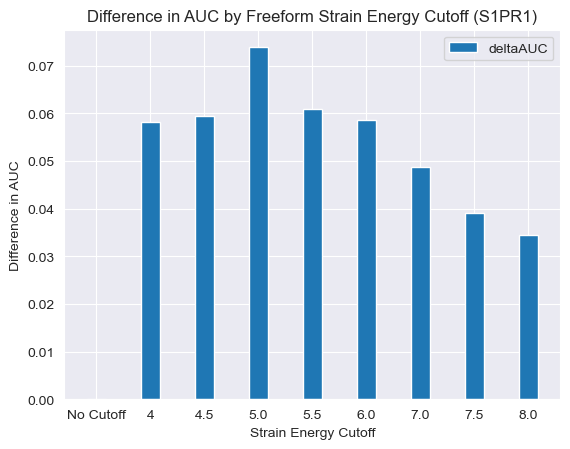

In [319]:
bar_plot_difference_in_auc_by_strain(all_data, total_e_thresholds, title_suffix)



In [320]:
def write_roc_metrics(data, thresholds, title_suffix):
    # Create a list to hold the data
    data_list = []

    # List to hold AUC values
    auc_values = []

    # Loop over each threshold
    for t in thresholds:
        # Filter the data based on 'Strain (kcal/mol)' threshold
        df = data if t is None else data[data["Strain (kcal/mol)"] <= t]

        # Get the true labels and scores
        y_true = df["Activity"]
        y_scores = df["r_i_docking_score"]

        # Inverting the scores
        y_scores_inverted = -y_scores

        # Compute the ROC curve and AUC with inverted scores
        fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
        roc_auc = auc(fpr, tpr)

        # Add AUC to the list
        auc_values.append(roc_auc)

        # Count the number of rows with Activity = 1 and the total number of rows
        activity_1_count = df[df["Activity"] == 1].shape[0]
        total_count = df.shape[0]

        # Add the data to the list
        data_list.append(
            {
                "Protein": title_suffix,
                "Strain Energy Cutoff": t if t is not None else "No Cutoff",
                "ROC_AUC": roc_auc,
                "Actives": activity_1_count,
                "Total Count": total_count,
            }
        )

    # Calculate differences in AUC
    auc_diff = [auc - auc_values[0] for auc in auc_values]

    # Add deltaAUC to the data list
    for i in range(len(data_list)):
        data_list[i]["deltaAUC"] = auc_diff[i]

    # Create a dataframe from the list
    df = pd.DataFrame(data_list)

    # Write the dataframe to a CSV file
    df.to_csv(f"./papermill/freeform_csv/strain_roc_metrics_{title_suffix}.csv", index=False)
    display(df)



In [321]:
write_roc_metrics(all_data, total_e_thresholds, title_suffix)


,Protein,Strain Energy Cutoff,ROC_AUC,Actives,Total Count,deltaAUC
0,S1PR1,No Cutoff,0.800735,215,9134,0.000000
1,S1PR1,4,0.858867,29,1095,0.058131
2,S1PR1,4.5,0.860177,41,1388,0.059442
3,S1PR1,5.0,0.874585,53,1815,0.073850
4,S1PR1,5.5,0.861641,61,2232,0.060906
5,S1PR1,6.0,0.859409,70,2661,0.058674
6,S1PR1,7.0,0.849457,96,3535,0.048721
7,S1PR1,7.5,0.839875,105,4000,0.039140
8,S1PR1,8.0,0.835250,113,4447,0.034515


  # Pareto

In [322]:
data = all_data
chosen_rank_amount = 20
rank_thresholds = [10, 20]



In [323]:
def identify_pareto(scores):
    population_size = scores.shape[0]
    pareto_front = np.ones(population_size, dtype=bool)
    for i in range(population_size):
        for j in range(population_size):
            if all(scores[j] <= scores[i]) and any(scores[j] < scores[i]):
                pareto_front[i] = 0
                break
    return np.where(pareto_front == 1)[0]


def find_pareto_ranks(scores, max_ranks=100):
    ranks = []
    remaining_scores = scores.copy()
    remaining_indices = np.arange(scores.shape[0])
    for _ in range(max_ranks):
        pareto_indices = identify_pareto(remaining_scores)
        ranks.append(remaining_indices[pareto_indices])
        remaining_scores = np.delete(remaining_scores, pareto_indices, axis=0)
        remaining_indices = np.delete(remaining_indices, pareto_indices)
        if remaining_scores.shape[0] == 0:
            break
    return ranks



In [324]:
# Extract the scores for the entire dataset
scores = data[["r_i_docking_score", "Strain (kcal/mol)"]].values

# Find the `chosen_rank_amount` of Pareto fronts until all points are classified or a max limit is reached
pareto_ranks_indices = find_pareto_ranks(
    scores, max_ranks=chosen_rank_amount
)  # Adjust max_ranks as needed



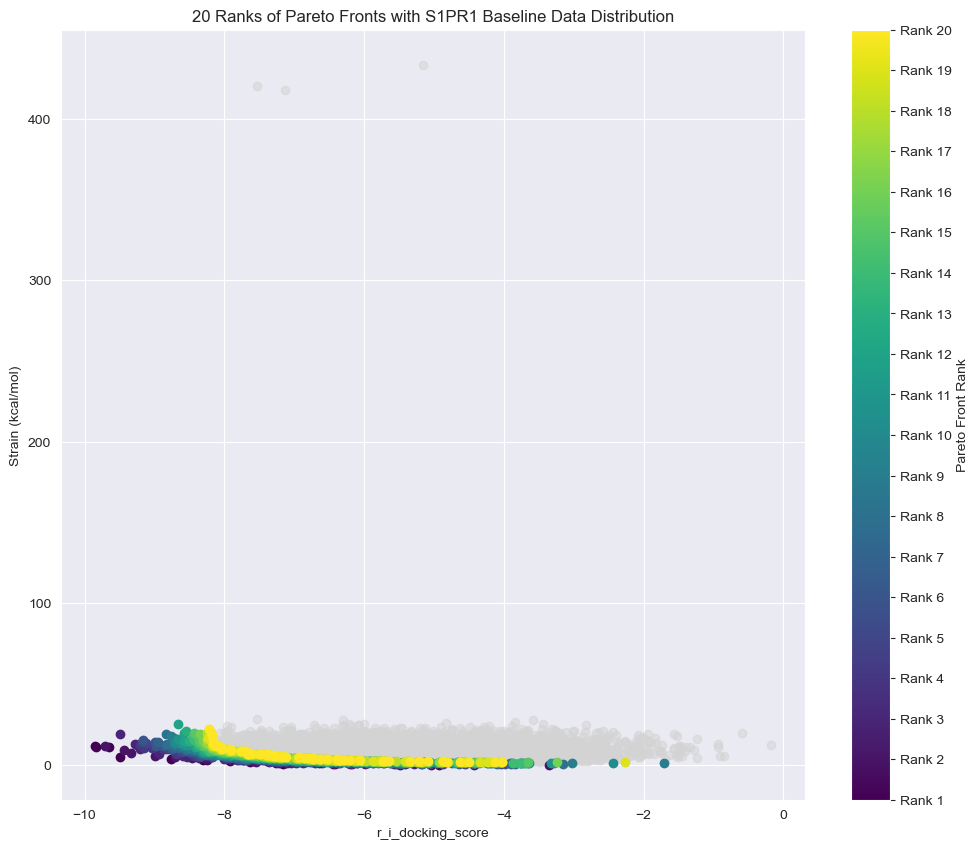

In [325]:
# Determine the actual number of ranks found
num_ranks = len(pareto_ranks_indices)

# Plot the baseline data distribution
plt.figure(figsize=(12, 10))
plt.scatter(
    data["r_i_docking_score"],
    data["Strain (kcal/mol)"],
    color="lightgrey",
    label="Baseline Data",
    alpha=0.5,
)

# Generate colors for each rank dynamically using a colormap
colormap = viridis
norm = Normalize(vmin=0, vmax=num_ranks - 1)

for i, indices in enumerate(pareto_ranks_indices):
    rank_data = data.iloc[indices]
    plt.scatter(
        rank_data["r_i_docking_score"],
        rank_data["Strain (kcal/mol)"],
        color=colormap(norm(i)),
        label=f"Rank {i+1}",
    )

# Create a custom legend
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), ticks=np.linspace(0, num_ranks - 1, num_ranks))
cbar.ax.set_yticklabels([f"Rank {i+1}" for i in range(num_ranks)])
cbar.set_label("Pareto Front Rank")

plt.title(
    f"{chosen_rank_amount} Ranks of Pareto Fronts with {title_suffix} Baseline Data Distribution"
)
plt.xlabel("r_i_docking_score")
plt.ylabel("Strain (kcal/mol)")

plt.grid(True)
plt.show()



In [326]:
# Count the number of Pareto points per rank and the total
num_points_per_rank = [len(indices) for indices in pareto_ranks_indices]
total_points = sum(num_points_per_rank)

# Print the counts
print("Number of Pareto points per rank:")
for rank, count in enumerate(num_points_per_rank, start=1):
    print(f"Rank {rank}: {count} points")

print(f"\nTotal Pareto points across all ranks: {total_points}")



Number of Pareto points per rank:
Rank 1: 15 points
Rank 2: 26 points
Rank 3: 29 points
Rank 4: 32 points
Rank 5: 37 points
Rank 6: 37 points
Rank 7: 41 points
Rank 8: 47 points
Rank 9: 50 points
Rank 10: 38 points
Rank 11: 51 points
Rank 12: 54 points
Rank 13: 55 points
Rank 14: 63 points
Rank 15: 54 points
Rank 16: 50 points
Rank 17: 45 points
Rank 18: 58 points
Rank 19: 57 points
Rank 20: 60 points

Total Pareto points across all ranks: 899


In [327]:
all_pareto_ranks_indices = np.concatenate(pareto_ranks_indices)
# display(data.iloc[all_pareto_ranks_indices])



In [328]:
pareto_front_df = data.iloc[all_pareto_ranks_indices]



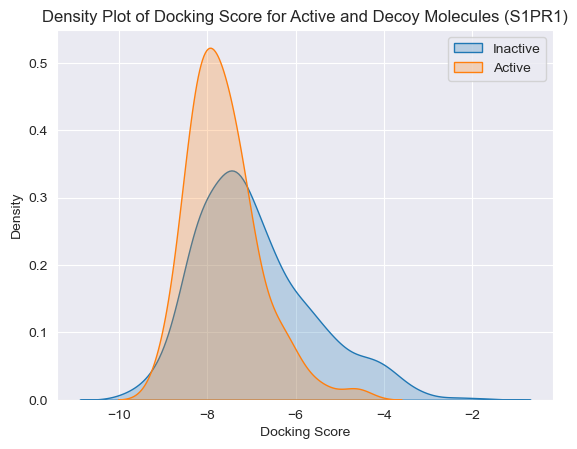

In [239]:
plot_density_docking(pareto_front_df, title_suffix)



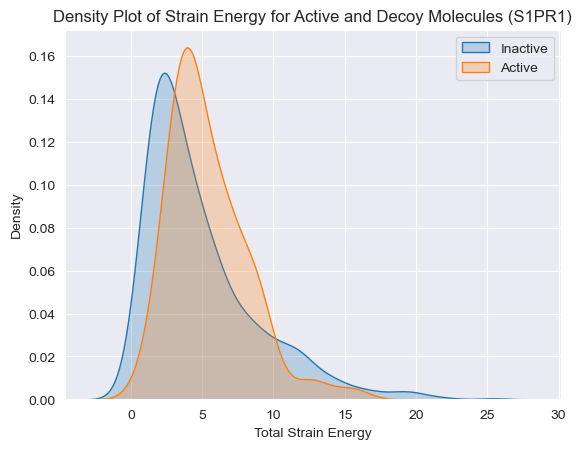

In [240]:
plot_density_strain(pareto_front_df, title_suffix)



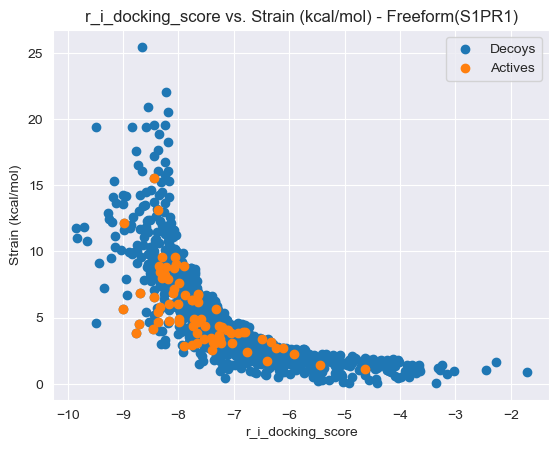

In [329]:
plt.scatter(pareto_front_df["r_i_docking_score"], pareto_front_df["Strain (kcal/mol)"])
actives_pareto_front_df = pareto_front_df[pareto_front_df["Activity"] == 1]
plt.scatter(
    actives_pareto_front_df["r_i_docking_score"], actives_pareto_front_df["Strain (kcal/mol)"]
)
plt.title(f"r_i_docking_score vs. Strain (kcal/mol) - Freeform({title_suffix})")
plt.xlabel("r_i_docking_score")
plt.ylabel("Strain (kcal/mol)")
plt.legend(["Decoys", "Actives"])
plt.show()



  # Pareto Enrichment

In [330]:
pareto_front_df = calculate_enrichment_parameters(pareto_front_df)



In [331]:
def enrichment_metrics(df):
    df = calculate_enrichment_parameters(df)
    closest_to_one_percent = df.iloc[
        (df["Percentage_Screened"] - 0.01).abs().argsort()[:1]
    ]
    ef1 = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent["Total_Actives"].values[0]
        * 100
    )
    closest_to_five_percent = df.iloc[
        (df["Percentage_Screened"] - 0.05).abs().argsort()[:1]
    ]
    ef5 = (
        closest_to_five_percent["Cumulative_Actives"].values[0]
        / closest_to_five_percent["Total_Actives"].values[0]
        * 100
    )
    return ef1, ef5



In [333]:
def compare_enrichment_metrics_for_ranks(
    df, pareto_ranks_indices, rank_thresholds, title_suffix=title_suffix
):
    # Calculate enrichment for the entire dataset
    ef1_full, ef5_full = enrichment_metrics(df)

    # Prepare plot
    labels = ["Baseline"] + [f"Top {rank} Ranks" for rank in rank_thresholds]
    ef1_values = [ef1_full]
    ef5_values = [ef5_full]

    # Calculate and append metrics for each specified rank threshold
    for rank_threshold in rank_thresholds:
        top_ranks_indices = np.concatenate(pareto_ranks_indices[:rank_threshold])
        subset_data = df.iloc[top_ranks_indices]
        ef1_subset, ef5_subset = enrichment_metrics(subset_data)
        ef1_values.append(ef1_subset)
        ef5_values.append(ef5_subset)

    # Plotting
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(
        # figsize=(10, 6)
    )
    rects1 = ax.bar(x - width / 2, ef1_values, width, label="EF1%")
    rects2 = ax.bar(x + width / 2, ef5_values, width, label="EF5%")

    ax.set_ylabel("Enrichment Factor (%)")
    ax.set_title(
        f"Enrichment Factors Comparison by Pareto Rank Threshold - Freeform {title_suffix}"
    )
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.legend()

    plt.tight_layout()
    plt.show()



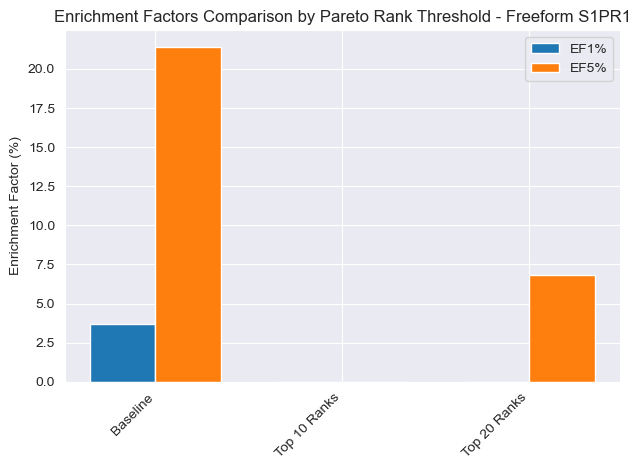

In [334]:
# Usage example
compare_enrichment_metrics_for_ranks(
    data, pareto_ranks_indices, rank_thresholds, title_suffix=title_suffix
)



In [336]:
def bar_plot_delta_enrichment_by_pareto(
    df, pareto_ranks_indices, rank_thresholds, title_suffix
):
    # Calculate enrichment for the entire dataset as baseline
    ef1_full, ef5_full = enrichment_metrics(df)

    # Initialize lists to store delta values
    delta_ef1s = []
    delta_ef5s = []

    # Calculate metrics for each specified rank threshold and compute deltas
    for rank_threshold in rank_thresholds:
        top_ranks_indices = np.concatenate(pareto_ranks_indices[:rank_threshold])
        subset_data = df.iloc[top_ranks_indices]
        ef1_subset, ef5_subset = enrichment_metrics(subset_data)

        # Calculate deltas compared to baseline
        delta_ef1s.append(ef1_subset - ef1_full)
        delta_ef5s.append(ef5_subset - ef5_full)

    # Create labels for the x-axis
    labels = [f"Top {rank} Ranks" for rank in rank_thresholds]

    # Create an array with the positions of each bar on the x axis
    x = np.arange(len(labels))

    # Set the width of the bars
    bar_width = 0.35

    # Plotting
    plt.figure()
    plt.bar(x - bar_width / 2, delta_ef1s, bar_width, label="ΔEF1%")
    plt.bar(x + bar_width / 2, delta_ef5s, bar_width, label="ΔEF5%")

    plt.title(f"Delta Enrichment Factors by Pareto Rank Threshold - Freeform ({title_suffix})")
    plt.xlabel("Pareto Rank Threshold")
    plt.ylabel("Delta Enrichment Factor (%)")
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()



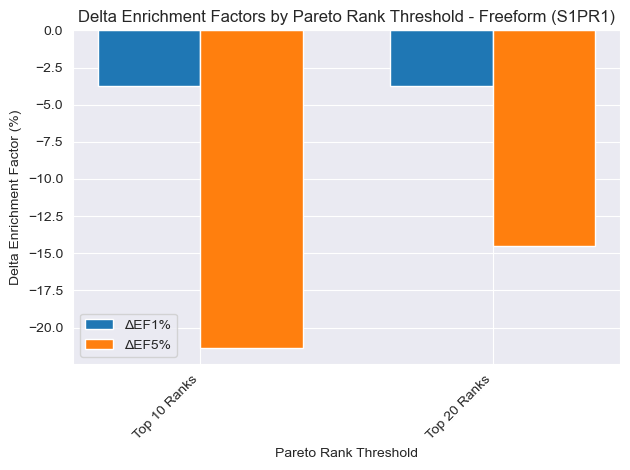

In [337]:
# Usage example, assuming `data`, `pareto_ranks_indices`, and `title_suffix` are defined
bar_plot_delta_enrichment_by_pareto(
    data, pareto_ranks_indices, rank_thresholds, title_suffix=title_suffix
)



In [339]:
def plot_enrichment_curve_by_pareto(
    df, pareto_indices, ax, label_prefix="", color="red"
):
    df = calculate_enrichment_parameters(df)
    ef1, ef5 = enrichment_metrics(df)
    enrichment_auc = auc(df["Percentage_Screened"], df["Fraction_Actives"])

    # Plot the enrichment curve
    ax.plot(
        df["Percentage_Screened"] * 100,
        df["Fraction_Actives"] * 100,
        label=f"{label_prefix}\nEnrichment AUC = {enrichment_auc:.2f}\n(EF1% = {ef1:.1f}%)\n(EF5% = {ef5:.0f}%)",
        color=color,
    )
    ax.legend()


def plot_enrichment_curves_by_pareto_ranks(
    data, pareto_ranks_indices, rank_thresholds, title_suffix
):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot for the entire dataset as a baseline
    plot_enrichment_curve_by_pareto(
        data, np.arange(len(data)), ax, label_prefix="Baseline", color="red"
    )

    # Define a colormap
    cmap = plt.get_cmap("viridis", len(rank_thresholds))

    # Plot enrichment curves for specified Pareto rank thresholds
    for i, rank_threshold in enumerate(rank_thresholds):
        top_ranks_indices = np.concatenate(pareto_ranks_indices[:rank_threshold])
        subset_data = data.iloc[top_ranks_indices]
        plot_enrichment_curve_by_pareto(
            subset_data,
            top_ranks_indices,
            ax,
            label_prefix=f"Top {rank_threshold} Ranks",
            color=cmap(i),
        )

    ax.set_title(f"Enrichment Curves by Pareto Rank Thresholds - Freeform ({title_suffix})")
    ax.set_xlabel("Percent Screened (%)")
    ax.set_ylabel("Percent Identified Actives (%)")
    plt.tight_layout()
    plt.show()



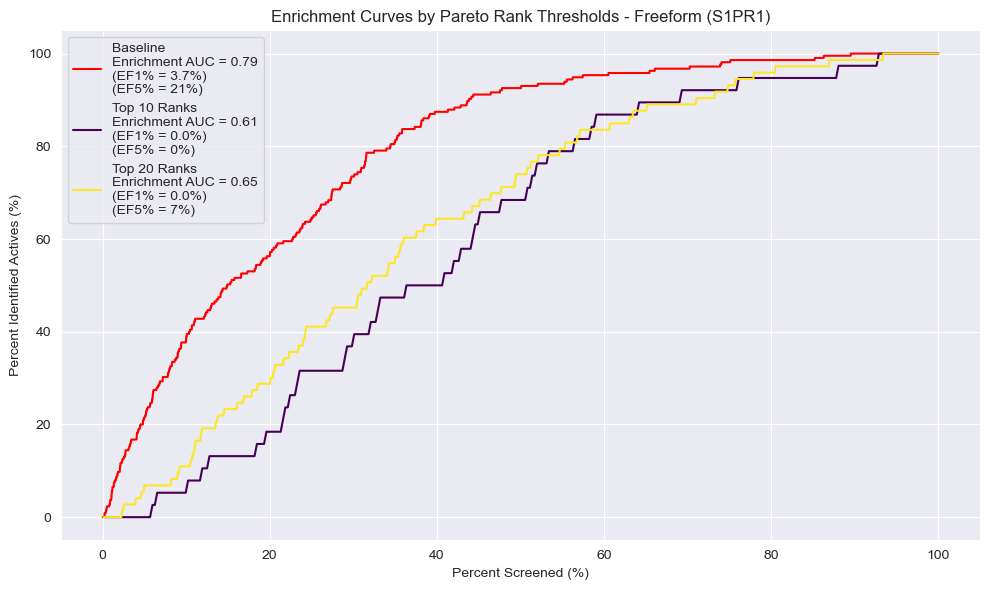

In [340]:
plot_enrichment_curves_by_pareto_ranks(
    data, pareto_ranks_indices, rank_thresholds, title_suffix
)



In [341]:
def write_enrichment_metrics_pareto(
    df, pareto_ranks_indices, rank_thresholds, title_suffix
):
    # Calculate enrichment for the entire dataset as baseline
    ef1_full, ef5_full = enrichment_metrics(df)

    # Initalize lists to store ef1 and ef5 values
    ef1_values = [ef1_full]
    ef5_values = [ef5_full]

    # Initialize lists to store delta values
    delta_ef1s = [0]  # The difference in EF1% for the baseline is 0
    delta_ef5s = [0]  # The difference in EF5% for the baseline is 0

    # Calculate metrics for each specified rank threshold and compute deltas
    for rank_threshold in rank_thresholds:
        top_ranks_indices = np.concatenate(pareto_ranks_indices[:rank_threshold])
        subset_data = df.iloc[top_ranks_indices]
        ef1_subset, ef5_subset = enrichment_metrics(subset_data)

        # Append metrics to lists
        ef1_values.append(ef1_subset)
        ef5_values.append(ef5_subset)

        # Calculate deltas compared to baseline
        delta_ef1s.append(ef1_subset - ef1_full)
        delta_ef5s.append(ef5_subset - ef5_full)

    # Create labels for the x-axis
    labels = ["No Cutoff"] + [f"Top {rank} Pareto Ranks" for rank in rank_thresholds]

    # Create a DataFrame with the data
    data = {
        "Protein": title_suffix,
        "Strain Energy Cutoff": labels,  # mimic prior data column header
        "EF1%": ef1_values,
        "EF5%": ef5_values,
        "deltaEF1%": delta_ef1s,
        "deltaEF5%": delta_ef5s,
    }
    df_to_csv = pd.DataFrame(data)

    # Write the DataFrame to a CSV file
    df_to_csv.to_csv(
        f"./papermill/freeform_csv/strain_enrichment_metrics_pareto_{title_suffix}.csv",
        index=False,
    )
    display(df_to_csv)


write_enrichment_metrics_pareto(
    data, pareto_ranks_indices, [10, 20], title_suffix=title_suffix
)


,Protein,Strain Energy Cutoff,EF1%,EF5%,deltaEF1%,deltaEF5%
0,S1PR1,No Cutoff,3.72093,21.395349,0.00000,0.000000
1,S1PR1,Top 10 Pareto Ranks,0.00000,0.000000,-3.72093,-21.395349
2,S1PR1,Top 20 Pareto Ranks,0.00000,6.849315,-3.72093,-14.546034


  # Pareto Linear Log ROC AUC

In [342]:
def logauc_by_pareto(df, pareto_ranks_indices, rank_thresholds, a=1e-3):
    # Filter the data based on the Pareto rank threshold, if provided
    if pareto_ranks_indices is not None:
        df = df.iloc[np.concatenate(pareto_ranks_indices[:rank_thresholds])]

    print(df.shape)

    y_scores_inverted = -df["r_i_docking_score"]

    fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

    valid_indices = np.where(fpr >= a)
    fpr_valid = fpr[valid_indices]
    tpr_valid = tpr[valid_indices]

    log_fpr_valid = np.log10(fpr_valid)

    linlog_auc = auc(log_fpr_valid, tpr_valid)

    ### NOTE TIMES 10 NOTE ###
    log_auc = (linlog_auc / -np.log10(a)) * 10

    return log_auc



In [344]:
def plot_log_aucs_pareto(data, pareto_ranks_indices, rank_thresholds, title_suffix):
    # Calculate log AUC for the entire dataset
    log_auc_all = logauc_by_pareto(data, None, None)

    # Calculate log AUC for each rank threshold
    log_aucs = [log_auc_all] + [
        logauc_by_pareto(data, pareto_ranks_indices, rank_threshold)
        for rank_threshold in rank_thresholds
    ]

    # Create labels for "All Data" and each rank threshold
    labels = ["Baseline"] + [f"Top {rank} Ranks" for rank in rank_thresholds]

    plt.bar(range(len(labels)), log_aucs, tick_label=labels)
    plt.title(f"Linear Log10 AUC by Pareto Rank Thresholds - Freeform ({title_suffix})")
    plt.xlabel("Pareto Rank Threshold")
    plt.ylabel("Linear Log10 AUC (x10)")
    plt.show()



(9134, 39)
(352, 39)
(899, 39)


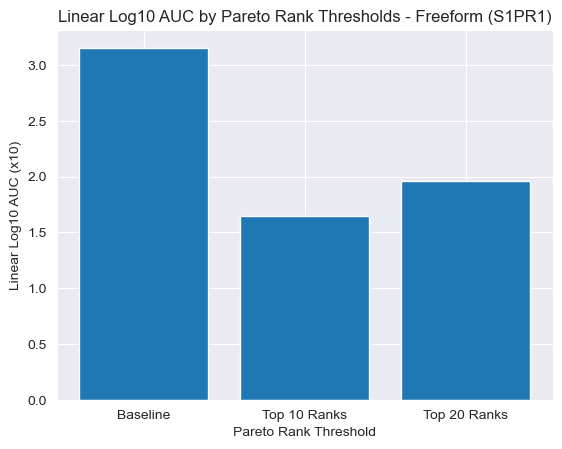

In [345]:
plot_log_aucs_pareto(data, pareto_ranks_indices, rank_thresholds, title_suffix)



In [346]:
def plot_delta_log_aucs_pareto(
    data, pareto_ranks_indices, rank_thresholds, title_suffix
):
    # Calculate log AUC for the entire dataset
    log_auc_all = logauc_by_pareto(data, None, None)

    # Calculate delta log AUC for each rank threshold
    delta_log_aucs = [log_auc_all - log_auc_all] + [
        logauc_by_pareto(data, pareto_ranks_indices, rank_threshold) - log_auc_all
        for rank_threshold in rank_thresholds
    ]

    # Create labels for "All Data" and each rank threshold
    labels = ["Baseline"] + [f"Top {rank} Ranks" for rank in rank_thresholds]

    plt.bar(range(len(labels)), delta_log_aucs, tick_label=labels)
    plt.title(f"Delta Linear Log10 AUC by Pareto Rank Thresholds - Freeform ({title_suffix})")
    plt.xlabel("Pareto Rank Threshold")
    plt.ylabel("Delta Linear Log10 AUC (x10)")
    plt.show()



(9134, 39)
(352, 39)
(899, 39)


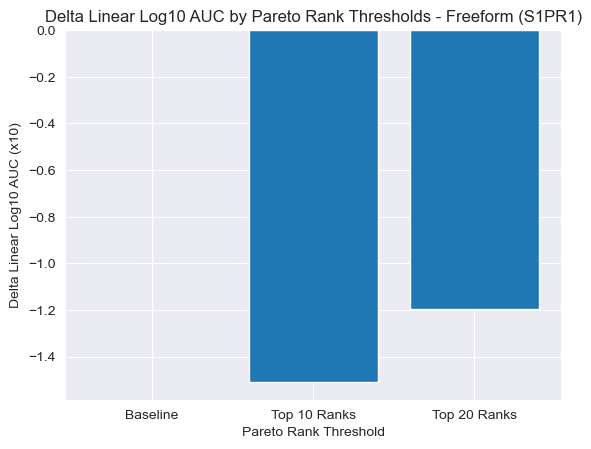

In [347]:
plot_delta_log_aucs_pareto(data, pareto_ranks_indices, rank_thresholds, title_suffix)



In [348]:
def plot_semi_log_roc_pareto(
    df, a=1e-3, pareto_ranks_indices=None, rank_threshold=None, ax=None, color="blue"
):
    # Filter the data based on the Pareto rank threshold, if provided
    if pareto_ranks_indices is not None:
        df = df.iloc[np.concatenate(pareto_ranks_indices[:rank_threshold])]

    y_scores_inverted = -df["r_i_docking_score"]

    fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

    valid_indices = np.where(fpr >= a)
    fpr_valid = fpr[valid_indices]
    tpr_valid = tpr[valid_indices]

    log_fpr_valid = np.log10(fpr_valid)

    linlog_auc = auc(log_fpr_valid, tpr_valid) / -np.log10(a)

    activity_1_count = df[df["Activity"] == 1].shape[0]
    total_count = df.shape[0]

    ax.plot(
        log_fpr_valid,
        tpr_valid,
        label=f"Pareto Rank: {rank_threshold if rank_threshold is not None else 'N/A'}, LogAUC: {linlog_auc:.2f}, Actives: {activity_1_count}, Total count: {total_count}",
        color=color,
    )
    ax.legend()



In [351]:
def plot_all_thresholds_pareto(df, pareto_ranks_indices, rank_thresholds, title_suffix):
    fig, ax = plt.subplots(figsize=(10, 10))

    plot_semi_log_roc_pareto(
        df, a=1e-3, pareto_ranks_indices=None, rank_threshold=None, ax=ax, color="red"
    )

    cmap = cm.get_cmap("viridis", len(rank_thresholds) + 1)

    for i, rank_threshold in enumerate(rank_thresholds):
        plot_semi_log_roc_pareto(
            df,
            a=1e-3,
            pareto_ranks_indices=pareto_ranks_indices,
            rank_threshold=rank_threshold,
            ax=ax,
            color=cmap(i),
        )

    ax.set_title(f"Pareto Rank Thresholds - Freeform ({title_suffix})")
    ax.set_xlabel("log(FPR)")
    ax.set_ylabel("TPR")

    plt.tight_layout()
    plt.show()



/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_53762/958485141.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis", len(rank_thresholds) + 1)


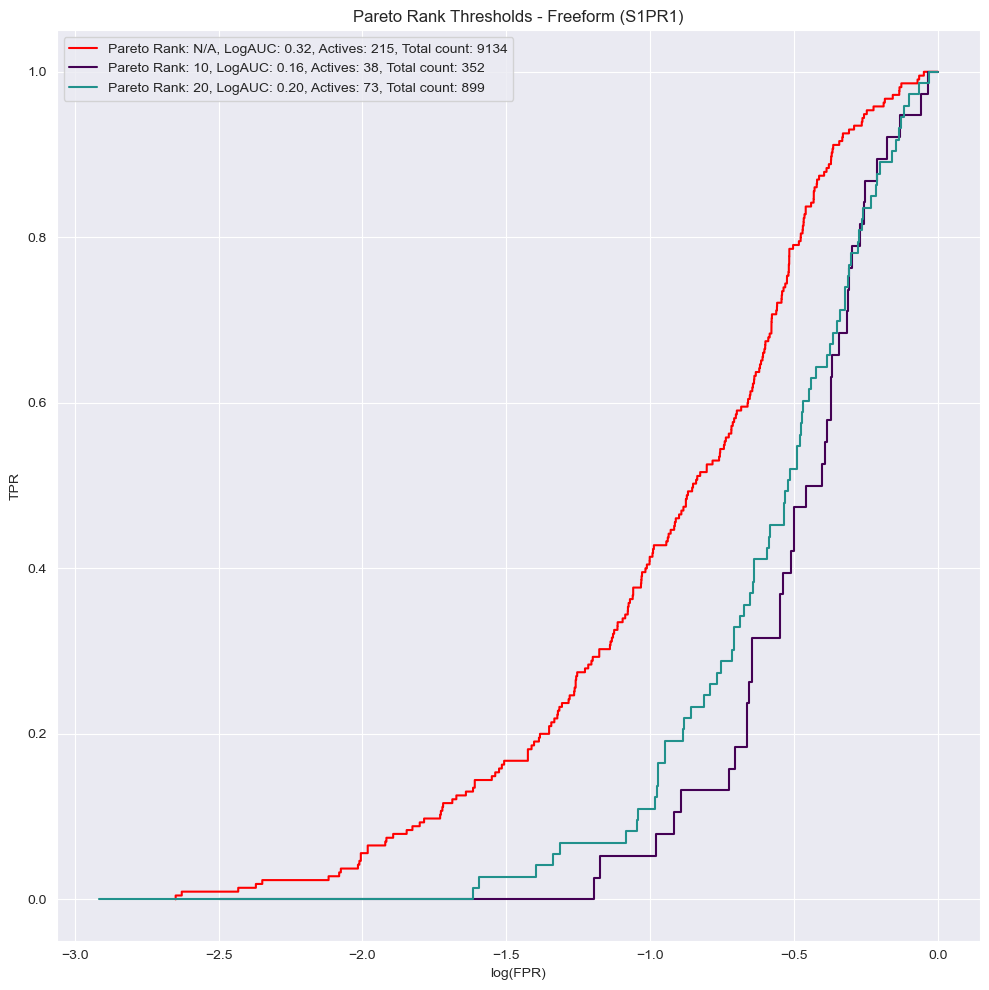

In [352]:
plot_all_thresholds_pareto(data, pareto_ranks_indices, rank_thresholds, title_suffix)



In [353]:
def write_log_aucs_pareto(data, pareto_ranks_indices, rank_thresholds, title_suffix):
    # Calculate log AUC for the entire dataset
    log_auc_all = logauc_by_pareto(data, None, None)

    # Calculate log AUC for each rank threshold
    log_aucs = [log_auc_all] + [
        logauc_by_pareto(data, pareto_ranks_indices, rank_threshold)
        for rank_threshold in rank_thresholds
    ]

    # Calculate delta log AUC for each rank threshold
    delta_log_aucs = [log_auc_all - log_auc_all] + [
        logauc_by_pareto(data, pareto_ranks_indices, rank_threshold) - log_auc_all
        for rank_threshold in rank_thresholds
    ]

    # Create labels for "All Data" and each rank threshold
    labels = ["No Cutoff"] + [f"Top {rank} Pareto Ranks" for rank in rank_thresholds]

    # Create a dataframe to hold the data
    df = pd.DataFrame(
        {
            "Protein": title_suffix,
            "Strain Energy Cutoff": labels,
            "Linear Log10 AUC (x10)": log_aucs,
            "Delta Linear Log10 AUC (x10)": delta_log_aucs,
        }
    )

    # Write the dataframe to a CSV file
    df.to_csv(f"./papermill/freeform_csv/strain_log_aucs_pareto_{title_suffix}.csv", index=False)
    display(df)



In [354]:
write_log_aucs_pareto(data, pareto_ranks_indices, rank_thresholds, title_suffix)



(9134, 39)
(352, 39)
(899, 39)
(352, 39)
(899, 39)


,Protein,Strain Energy Cutoff,Linear Log10 AUC (x10),Delta Linear Log10 AUC (x10)
0,S1PR1,No Cutoff,3.154225,0.000000
1,S1PR1,Top 10 Pareto Ranks,1.645113,-1.509113
2,S1PR1,Top 20 Pareto Ranks,1.957811,-1.196415


  # Pareto ROC AUC

In [355]:
def plot_roc_curve_inverted_pareto(
    data, pareto_ranks_indices, rank_threshold, ax, title_suffix, color="blue"
):
    # Filter the data based on 'Strain (kcal/mol)' threshold
    if pareto_ranks_indices is None:
        df = data
    else:
        df = data.iloc[np.concatenate(pareto_ranks_indices[:rank_threshold])]

    # Get the true labels and scores
    y_true = df["Activity"]
    y_scores = df["r_i_docking_score"]

    # Inverting the scores
    y_scores_inverted = -y_scores

    # Compute the ROC curve and AUC with inverted scores
    fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
    roc_auc = auc(fpr, tpr)

    # Count the number of rows with Activity = 1 and the total number of rows
    activity_1_count = df[df["Activity"] == 1].shape[0]
    total_count = df.shape[0]

    # Plotting the ROC curve
    ax.plot(
        fpr,
        tpr,
        lw=2,
        label=f"Pareto Rank: {rank_threshold if rank_thresholds is not None else 'N/A'}, ROC curve (AUC = {roc_auc:.2f}), Actives: {activity_1_count}, Total Count: {total_count}",
        color=color,
    )

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(
        f"Receiver Operating Characteristic (Inverted Scores) ({title_suffix})"
    )



In [357]:
def plot_all_roc_thresholds_pareto(
    df, pareto_ranks_indices, rank_thresholds, title_suffix
):
    fig, ax = plt.subplots(figsize=(10, 10))

    plot_roc_curve_inverted_pareto(
        df,
        pareto_ranks_indices=None,
        rank_threshold=None,
        ax=ax,
        color="red",
        title_suffix=title_suffix,
    )

    cmap = cm.get_cmap("viridis", len(rank_thresholds) + 1)

    for i, rank_threshold in enumerate(rank_thresholds):
        plot_roc_curve_inverted_pareto(
            df,
            pareto_ranks_indices=pareto_ranks_indices,
            rank_threshold=rank_threshold,
            ax=ax,
            color=cmap(i),
            title_suffix=title_suffix,
        )

    ax.set_title(f"Pareto Rank Thresholds - Freeform ({title_suffix})")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")

    ax.legend()

    plt.tight_layout()
    plt.show()



/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_53762/3373751377.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis", len(rank_thresholds) + 1)


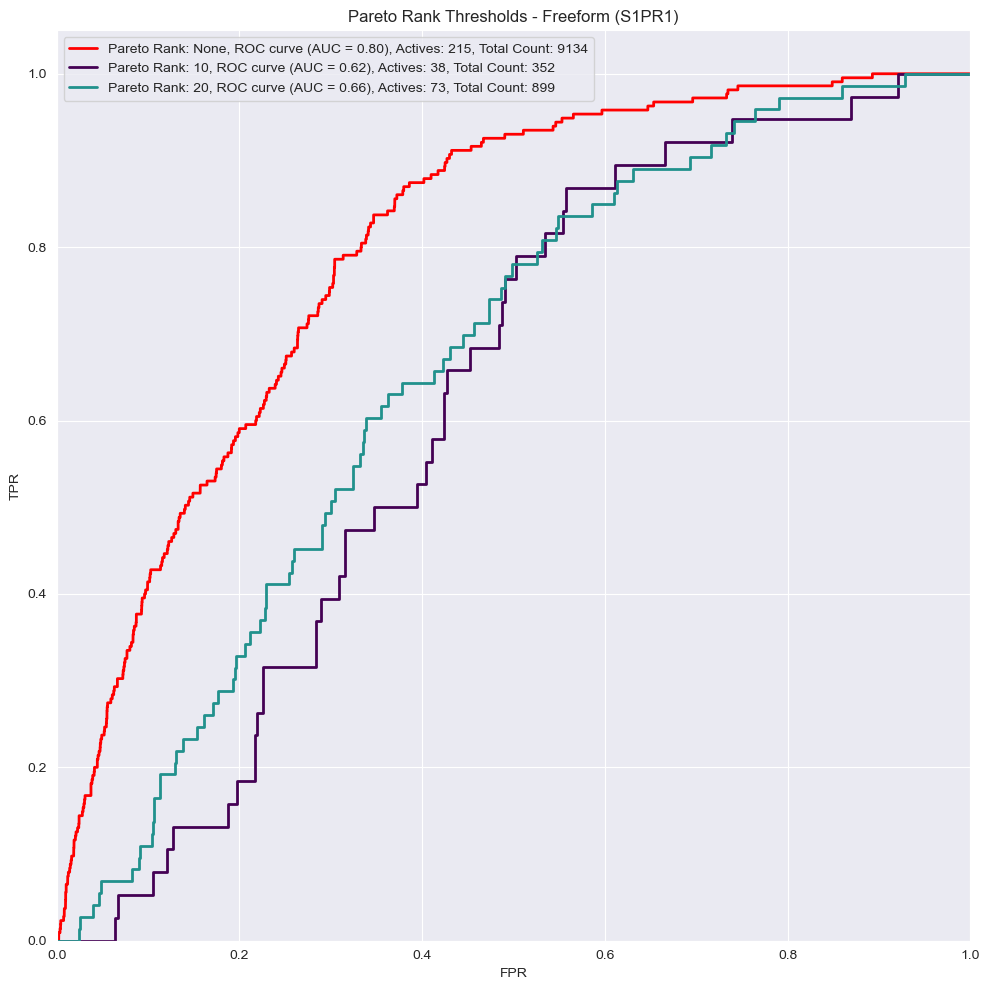

In [358]:
plot_all_roc_thresholds_pareto(
    df=data,
    pareto_ranks_indices=pareto_ranks_indices,
    rank_thresholds=rank_thresholds,
    title_suffix=title_suffix,
)



In [360]:
def bar_plot_difference_in_auc_by_pareto(
    data, pareto_ranks_indices, rank_thresholds, title_suffix
):
    # Get the true labels and scores for the entire dataset
    y_true = data["Activity"]
    y_scores = data["r_i_docking_score"]

    # Inverting the scores
    y_scores_inverted = -y_scores

    # Compute the ROC curve and AUC with inverted scores for the entire dataset
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores_inverted)
    baseline_auc = auc(fpr, tpr)

    # Create a list to hold AUC values
    auc_values = []

    # Add the baseline AUC to the list of AUC values
    auc_values.append(baseline_auc)

    # Loop over each rank threshold
    for rank_threshold in rank_thresholds:
        # Filter the data based on Pareto rank threshold
        df = (
            data
            if rank_threshold is None
            else data.iloc[np.concatenate(pareto_ranks_indices[:rank_threshold])]
        )

        # Get the true labels and scores
        y_true = df["Activity"]
        y_scores = df["r_i_docking_score"]

        # Inverting the scores
        y_scores_inverted = -y_scores

        # Compute the ROC curve and AUC with inverted scores
        fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores_inverted)
        roc_auc = auc(fpr, tpr)

        # Add AUC to the list
        auc_values.append(roc_auc)

    # Calculate differences in AUC against the baseline
    auc_diff = [auc - baseline_auc for auc in auc_values]

    # Create labels for the x-axis
    x_labels = ["Baseline"] + [
        str(t) if t is not None else "No Cutoff" for t in rank_thresholds
    ]

    # Create an array with the positions of each bar on the x axis
    x = np.arange(len(x_labels))

    # Set the width of the bars
    bar_width = 0.35

    plt.bar(x, auc_diff, bar_width, label="deltaAUC")
    plt.title(f"Difference in AUC by Pareto Rank Threshold - Freeform ({title_suffix})")
    plt.xlabel("Pareto Rank Threshold")
    plt.ylabel("Difference in AUC")
    plt.xticks(x, x_labels)  # Set the position and labels of the xticks
    plt.legend()
    plt.show()



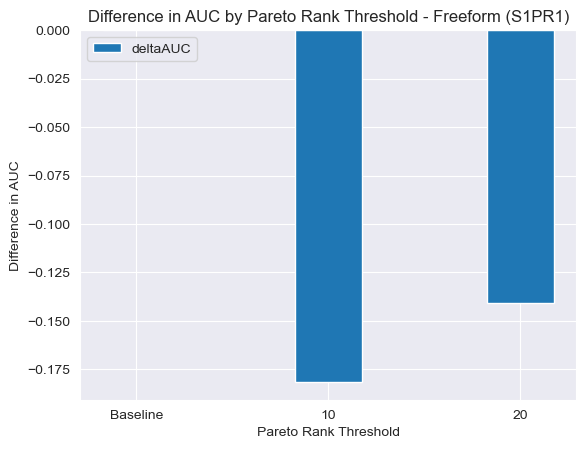

In [361]:
bar_plot_difference_in_auc_by_pareto(
    data, pareto_ranks_indices, rank_thresholds, title_suffix
)



In [362]:
def write_pareto_roc_metrics(data, pareto_ranks_indices, rank_thresholds, title_suffix):
    # Create a list to hold the data
    data_list = []

    # Get the true labels and scores for the entire dataset
    y_true = data["Activity"]
    y_scores = data["r_i_docking_score"]

    # Inverting the scores
    y_scores_inverted = -y_scores

    # Compute the ROC curve and AUC with inverted scores for the entire dataset
    fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
    baseline_auc = auc(fpr, tpr)

    # Count the number of rows with Activity = 1 and the total number of rows for the entire dataset
    activity_1_count = data[data["Activity"] == 1].shape[0]
    total_count = data.shape[0]

    # Add the baseline data to the list
    data_list.append(
        {
            "Protein": title_suffix,
            "Strain Energy Cutoff": "No Cutoff",
            "ROC_AUC": baseline_auc,
            "Actives": activity_1_count,
            "Total Count": total_count,
            "deltaAUC": 0,  # The difference in AUC for the baseline is 0
        }
    )

    # Loop over each rank threshold
    for rank_threshold in rank_thresholds:
        # Filter the data based on Pareto rank threshold
        df = data.iloc[np.concatenate(pareto_ranks_indices[:rank_threshold])]

        # Get the true labels and scores
        y_true = df["Activity"]
        y_scores = df["r_i_docking_score"]

        # Inverting the scores
        y_scores_inverted = -y_scores

        # Compute the ROC curve and AUC with inverted scores
        fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
        roc_auc = auc(fpr, tpr)

        # Count the number of rows with Activity = 1 and the total number of rows
        activity_1_count = df[df["Activity"] == 1].shape[0]
        total_count = df.shape[0]

        # Add the data to the list
        data_list.append(
            {
                "Protein": title_suffix,
                "Strain Energy Cutoff": "Top {} Pareto Ranks".format(rank_threshold),
                "ROC_AUC": roc_auc,
                "Actives": activity_1_count,
                "Total Count": total_count,
                "deltaAUC": roc_auc
                - baseline_auc,  # Calculate the difference in AUC against the baseline
            }
        )

    # Create a dataframe from the list
    df = pd.DataFrame(data_list)

    # Write the dataframe to a CSV file
    df.to_csv(
        f"./papermill/freeform_csv/strain_roc_metrics_pareto_{title_suffix}.csv", index=False
    )
    display(df)



In [363]:
write_pareto_roc_metrics(data, pareto_ranks_indices, rank_thresholds, title_suffix)


,Protein,Strain Energy Cutoff,ROC_AUC,Actives,Total Count,deltaAUC
0,S1PR1,No Cutoff,0.800735,215,9134,0.00000
1,S1PR1,Top 10 Pareto Ranks,0.619175,38,352,-0.18156
2,S1PR1,Top 20 Pareto Ranks,0.660105,73,899,-0.14063


  # Pareto Ranks as Scores

  1. Calculate Pareto ranks of an the entire dataset

  2. For Enrichment: Rank order by pareto rank (however that is an awkward implementation, as large sets of compounds will share a rank)

  3. for ROC-AUC and ROC-logAUC, pareto ranking becomes the scoring function.

  We need a new find_pareto_ranks() that does not have a limit on the amount of ranks.

In [364]:
def find_all_pareto_ranks(scores):
    ranks = []
    remaining_scores = scores.copy()
    remaining_indices = np.arange(scores.shape[0])
    while remaining_scores.shape[0] > 0:
        pareto_indices = identify_pareto(remaining_scores)
        ranks.append(remaining_indices[pareto_indices])
        remaining_scores = np.delete(remaining_scores, pareto_indices, axis=0)
        remaining_indices = np.delete(remaining_indices, pareto_indices)
    return ranks



  # Due to the length of time to calculate all the pareto fronts and their ranks, we are temporarily saving that data to file. This needs to be removed in papermill execution or we will get incorrect results.

In [365]:
# Extract the scores for the entire dataset

scores = data[["r_i_docking_score", "Strain (kcal/mol)"]].values

# ! TEMPORARY COMMENTED OUT FOR TESTING
total_pareto_ranks_indices = find_all_pareto_ranks(scores)



In [366]:
# import pickle

# ! TEMPORARY COMMENTED OUT FOR TESTING
# ! FILE IS SAVED
# with open('pareto_ranks.pkl', 'wb') as f:
#   pickle.dump(total_pareto_ranks_indices, f)



In [367]:
# with open('pareto_ranks.pkl', 'rb') as f:
#   total_pareto_ranks_indices = pickle.load(f)



In [368]:
total_pareto_ranks_indices[:][0]



array([   0,    1,    3,    5,   35,  115,  136,  271,  283,  493,  938,
       1102, 5024, 6033, 6266])

In [369]:
# Count the number of Pareto points per rank and the total
num_points_per_rank = [len(indices) for indices in total_pareto_ranks_indices]
total_points = sum(num_points_per_rank)

# Print the counts
print("Number of Pareto points per rank:")
for rank, count in enumerate(num_points_per_rank, start=1):
    print(f"Rank {rank}: {count} points")

print(f"\nTotal Pareto points across all ranks: {total_points}")



Number of Pareto points per rank:
Rank 1: 15 points
Rank 2: 26 points
Rank 3: 29 points
Rank 4: 32 points
Rank 5: 37 points
Rank 6: 37 points
Rank 7: 41 points
Rank 8: 47 points
Rank 9: 50 points
Rank 10: 38 points
Rank 11: 51 points
Rank 12: 54 points
Rank 13: 55 points
Rank 14: 63 points
Rank 15: 54 points
Rank 16: 50 points
Rank 17: 45 points
Rank 18: 58 points
Rank 19: 57 points
Rank 20: 60 points
Rank 21: 63 points
Rank 22: 71 points
Rank 23: 54 points
Rank 24: 58 points
Rank 25: 59 points
Rank 26: 64 points
Rank 27: 60 points
Rank 28: 66 points
Rank 29: 72 points
Rank 30: 73 points
Rank 31: 65 points
Rank 32: 68 points
Rank 33: 75 points
Rank 34: 62 points
Rank 35: 62 points
Rank 36: 75 points
Rank 37: 61 points
Rank 38: 74 points
Rank 39: 71 points
Rank 40: 71 points
Rank 41: 82 points
Rank 42: 70 points
Rank 43: 74 points
Rank 44: 75 points
Rank 45: 70 points
Rank 46: 65 points
Rank 47: 64 points
Rank 48: 75 points
Rank 49: 70 points
Rank 50: 71 points
Rank 51: 74 points
Rank 5

In [370]:
# Determine the actual number of ranks found
num_ranks = len(total_pareto_ranks_indices)
print(
    f"Number of Pareto ranks found: {num_ranks}, in total containing {total_points} points, original data is {data.shape}."
)


Number of Pareto ranks found: 183, in total containing 9134 points, original data is (9134, 39).


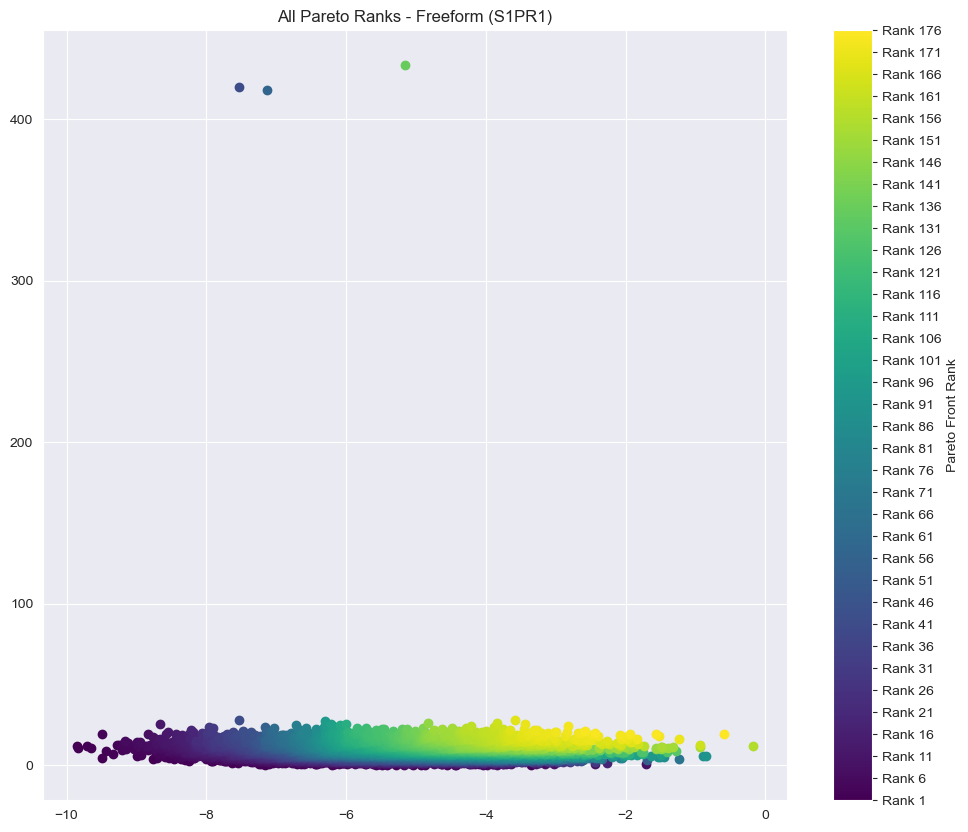

In [371]:
# Create a new figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# Normalize color gradient based on num_ranks, be careful how it is defined in the code
norm = plt.cm.colors.Normalize(vmin=0, vmax=num_ranks - 1)

# Set the title
ax.set_title(f"All Pareto Ranks - Freeform ({title_suffix})")

# Use the axes for the scatter plots
ax.scatter(
    data["r_i_docking_score"],
    data["Strain (kcal/mol)"],
    color="lightgrey",
    label="Baseline Data",
    alpha=0.5,
)

for i, indices in enumerate(total_pareto_ranks_indices):
    rank_data = data.iloc[indices]
    ax.scatter(
        rank_data["r_i_docking_score"],
        rank_data["Strain (kcal/mol)"],
        color=colormap(norm(i)),
        label=f"Rank {i+1}",
    )

# Use the axes for the colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
# Reduce the number of ticks on the colorbar
cbar = fig.colorbar(sm, ax=ax, ticks=np.linspace(0, num_ranks - 1, num_ranks // 5))
cbar.ax.set_yticklabels([f"Rank {i*5+1}" for i in range(num_ranks // 5)])
cbar.set_label("Pareto Front Rank")

plt.grid(True)
plt.show()



In [276]:
all_pareto_indices = np.concatenate(total_pareto_ranks_indices)
# Remember ".iloc" is indices based, even the df.index has both indices and labels
all_pareto_front_df = data.iloc[all_pareto_indices]
display(all_pareto_front_df.head())
display(data.head())
display(total_pareto_ranks_indices[:][0])
display(all_pareto_indices[:4])
display(all_pareto_front_df.index)



,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Strain (kcal/mol),CPU Time (s),Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened
1,C49722056_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x30bccd380>,0,S1PR1_chembl19_set_decoy_sc.smi,8761,53161,0,S-OPLS,69.1221,1,C49722056_Isomer1-1,S1PR1,8759,8,-9.85344,-0.339774,-1.04389,-2.25619,-9.85344,-3.25617,-0.614393,0,-2.47204,-28.2721,-17.6101,0.750268,-0.205978,-55.7628,-45.8823,9.26404,116,131,0,11.74,17.688470,0,215,0.000000,0.000109
2,C04317377_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x30ba1e3b0>,0,S1PR1_chembl19_set_decoy_sc.smi,10287,53161,0,S-OPLS,46.2507,1,C04317377_Isomer1-1,S1PR1,10285,7,-9.83913,-0.351397,-1.06705,-2.27116,-9.83913,-3.66966,-0.51143,-0,-1.93605,-32.6817,-17.4599,0.879162,-0.34808,-79.9822,-50.1416,8.97027,47,6,0,10.98,10.345523,0,215,0.000000,0.000219
4,C23663588_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x30ba1e490>,0,S1PR1_chembl19_set_decoy_sc.smi,8841,53161,0,S-OPLS,73.0516,1,C23663588_Isomer1-1,S1PR1,8839,10,-9.65606,-0.275887,-0.902446,-2.11972,-9.65606,-4.21537,-0.227277,-0,-1.20212,-45.9255,-14.3982,0.757076,-0.312361,-89.9527,-60.3237,11.0262,142,31,0,10.82,18.226108,0,215,0.000000,0.000438
6,C40564286_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x30ba1e570>,0,S1PR1_chembl19_set_decoy_sc.smi,1717,53161,0,S-OPLS,34.0305,1,C40564286_Isomer1-1,S1PR1,1716,8,-9.48587,-0.316196,-0.982493,-2.15529,-9.48587,-3.23094,-0.664013,-0,-1.98766,-39.649,-12.1225,0.332075,-0.134512,-80.9499,-51.7715,5.3948,18,267,0,4.60,11.292540,0,215,0.000000,0.000657
36,ML056-3V2Y_Isomer2,<rdkit.Chem.rdchem.Mol object at 0x30bccd310>,1,S1PR1_chembl19_set_active_sc.smi,221,53161,0,S-OPLS,9.90503,1,ML056-3V2Y_Isomer2-1,S1PR1,220,11,-8.75918,-0.380834,-1.08304,-2.11805,-8.75918,-3.18907,-0.626235,0,-1.98162,-33.3969,-16.7374,1.46352,-0.245317,-86.9593,-50.1343,8.63688,258,112,0,3.87,14.857316,3,215,0.013953,0.003941


,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Strain (kcal/mol),CPU Time (s),Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened
1,C49722056_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x30bccd380>,0,S1PR1_chembl19_set_decoy_sc.smi,8761,53161,0,S-OPLS,69.1221,1,C49722056_Isomer1-1,S1PR1,8759,8,-9.85344,-0.339774,-1.04389,-2.25619,-9.85344,-3.25617,-0.614393,0,-2.47204,-28.2721,-17.6101,0.750268,-0.205978,-55.7628,-45.8823,9.26404,116,131,0,11.74,17.688470,0,215,0.0,0.000109
2,C04317377_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x30ba1e3b0>,0,S1PR1_chembl19_set_decoy_sc.smi,10287,53161,0,S-OPLS,46.2507,1,C04317377_Isomer1-1,S1PR1,10285,7,-9.83913,-0.351397,-1.06705,-2.27116,-9.83913,-3.66966,-0.51143,-0,-1.93605,-32.6817,-17.4599,0.879162,-0.34808,-79.9822,-50.1416,8.97027,47,6,0,10.98,10.345523,0,215,0.0,0.000219
3,C19105680_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x30ba1e340>,0,S1PR1_chembl19_set_decoy_sc.smi,630,53161,0,S-OPLS,23.1056,1,C19105680_Isomer1-1,S1PR1,629,9,-9.71223,-0.303507,-0.963575,-2.17483,-9.71223,-3.65966,-0.450318,-0,-1.14136,-49.6285,-14.9813,0.641197,-0.373474,-95.1118,-64.6098,12.0046,41,221,0,11.84,11.455528,0,215,0.0,0.000328
4,C23663588_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x30ba1e490>,0,S1PR1_chembl19_set_decoy_sc.smi,8841,53161,0,S-OPLS,73.0516,1,C23663588_Isomer1-1,S1PR1,8839,10,-9.65606,-0.275887,-0.902446,-2.11972,-9.65606,-4.21537,-0.227277,-0,-1.20212,-45.9255,-14.3982,0.757076,-0.312361,-89.9527,-60.3237,11.0262,142,31,0,10.82,18.226108,0,215,0.0,0.000438
5,C59038567_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x30ba1e420>,0,S1PR1_chembl19_set_decoy_sc.smi,1625,53161,0,S-OPLS,38.6831,1,C59038567_Isomer1-1,S1PR1,1624,10,-9.48706,-0.306034,-0.96137,-2.13962,-9.48706,-2.82232,-0.28602,-0,-2.46198,-50.2272,-12.3858,0.79367,-0.341173,-99.648,-62.6131,4.81627,142,195,0,19.38,14.082284,0,215,0.0,0.000547


array([   0,    1,    3,    5,   35,  115,  136,  271,  283,  493,  938,
       1102, 5024, 6033, 6266])

array([0, 1, 3, 5])

Index([   1,    2,    4,    6,   36,  116,  137,  272,  284,  494,
       ...
       9102, 8952, 9004, 9080, 9115, 9027, 9052, 9097, 9111, 9133],
      dtype='int64', length=9134)

In [277]:
# display(all_pareto_front_df.loc[1].to_frame().T)
# display(all_pareto_front_df.iloc[0].to_frame().T)


  `all_pareto_front_df` is in the correct "order" of pareto fronts by rank, however that is not very useful directly. as points in a front are considered "optimal". while I didn't intentionall set it: the ranks themselves are ordered by docking score **within** the rank itself. this could be useful later, so I don't want to disregard it.

  however, what we need right now is the ability to map `total_pareto_ranks_indices` to the `all_pareto_front_df` dataframe. `total_pareto_ranks_indices` is a list of arrays containing the pareto front points, by their rank

In [278]:
print(total_pareto_ranks_indices[0])
len(total_pareto_ranks_indices)



[   0    1    3    5   35  115  136  271  283  493  938 1102 5024 6033
 6266]


183

In [279]:
for rank, indices in enumerate(total_pareto_ranks_indices):
    print(f"Rank {rank+1}: {indices} points")



Rank 1: [   0    1    3    5   35  115  136  271  283  493  938 1102 5024 6033
 6266] points
Rank 2: [   2    6    7   20   41   73  100  122  129  290  409  508  560  579
  940  993 1184 1988 2122 2204 2592 2679 3250 5203 7237 8668] points
Rank 3: [   4    8    9   10   24   26   54   65  156  223  339  384  400  590
  684  756  809 1044 1149 1194 1293 1410 1608 2642 3343 3793 4811 5515
 6998] points
Rank 4: [  11   14   15   17   27   31   38   44   80   81   96  243  265  342
  355  391  613  827  843  939 1540 1807 2269 2787 3309 3363 3520 4435
 4898 5741 6373 7199] points
Rank 5: [  12   16   19   21   33   45   51   71   75   92   94  160  244  257
  274  316  335  345  433  441  710  859  871  883 1437 1565 1667 1890
 2433 2844 4074 4498 5019 5988 6000 7780 7847] points
Rank 6: [  13   18   22   23   28   36   58   68   69   84  105  109  158  248
  258  319  365  477  588  779  821  952 1061 1157 1518 1934 2007 2667
 3146 3494 4253 4706 4926 5192 5724 6829 7922] points
Rank 7: 

  Because of how we handled the enrichment calculations (setting index values to start at 1 and not 0), we now need a work around for using iloc. I don't really get why, but I can't get a solution other than the strange one below.

  iloc is indices based, **this is different than saying index based**, so iloc[0] is the first row of your dataframe. when we set our **labels** to start at 1, the index value we see as iloc[0] is 1

  total_pareto_rank_indices has the actual **indicies** of the dataframe, which require using iloc to access successfully, unless we want to redo the index labels. i am too worried right now that this will introduce new problems somehow, so i don't want to touch it.

  instead, we need to use get_loc. this is very unintuitive because you would think that get_loc (a pandas function) would return something you would use for df.loc related tasks. but no, get_loc is a method of the index class and is used to get the indice for a labeled index value in the dataframe.

  get_loc() here is actually returning just one number, that is whatever the column based index that ParetoRank is.

  also, i should have really handled my version control differently. this should have been a branch so i could have definitely kept the working completely okay code. i should have also used git tag to confirm that the code works

In [280]:
# Create a copy of the original dataframe, data
df_copy = data.copy()

# Create a new column 'ParetoRank' with default value NaN
df_copy["ParetoRank"] = np.nan

# Get the integer position of the 'ParetoRank' column
pareto_rank_col_index = df_copy.columns.get_loc("ParetoRank")

# Loop over each rank and its indices
for rank, indices in enumerate(total_pareto_ranks_indices):
    # Update 'ParetoRank' for the rows at the current indices to the current rank
    df_copy.iloc[indices, pareto_rank_col_index] = rank + 1



In [281]:
df_copy



,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Strain (kcal/mol),CPU Time (s),Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened,ParetoRank
1,C49722056_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x30bccd380>,0,S1PR1_chembl19_set_decoy_sc.smi,8761,53161,0,S-OPLS,69.1221,1,C49722056_Isomer1-1,S1PR1,8759,8,-9.853440,-0.339774,-1.04389,-2.25619,-9.85344,-3.25617,-0.614393,0,-2.47204,-28.2721,-17.6101,0.750268,-0.205978,-55.7628,-45.8823,9.26404,116,131,0,11.74,17.688470,0,215,0.0,0.000109,1.0
2,C04317377_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x30ba1e3b0>,0,S1PR1_chembl19_set_decoy_sc.smi,10287,53161,0,S-OPLS,46.2507,1,C04317377_Isomer1-1,S1PR1,10285,7,-9.839130,-0.351397,-1.06705,-2.27116,-9.83913,-3.66966,-0.51143,-0,-1.93605,-32.6817,-17.4599,0.879162,-0.34808,-79.9822,-50.1416,8.97027,47,6,0,10.98,10.345523,0,215,0.0,0.000219,1.0
3,C19105680_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x30ba1e340>,0,S1PR1_chembl19_set_decoy_sc.smi,630,53161,0,S-OPLS,23.1056,1,C19105680_Isomer1-1,S1PR1,629,9,-9.712230,-0.303507,-0.963575,-2.17483,-9.71223,-3.65966,-0.450318,-0,-1.14136,-49.6285,-14.9813,0.641197,-0.373474,-95.1118,-64.6098,12.0046,41,221,0,11.84,11.455528,0,215,0.0,0.000328,2.0
4,C23663588_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x30ba1e490>,0,S1PR1_chembl19_set_decoy_sc.smi,8841,53161,0,S-OPLS,73.0516,1,C23663588_Isomer1-1,S1PR1,8839,10,-9.656060,-0.275887,-0.902446,-2.11972,-9.65606,-4.21537,-0.227277,-0,-1.20212,-45.9255,-14.3982,0.757076,-0.312361,-89.9527,-60.3237,11.0262,142,31,0,10.82,18.226108,0,215,0.0,0.000438,1.0
5,C59038567_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x30ba1e420>,0,S1PR1_chembl19_set_decoy_sc.smi,1625,53161,0,S-OPLS,38.6831,1,C59038567_Isomer1-1,S1PR1,1624,10,-9.487060,-0.306034,-0.96137,-2.13962,-9.48706,-2.82232,-0.28602,-0,-2.46198,-50.2272,-12.3858,0.79367,-0.341173,-99.648,-62.6131,4.81627,142,195,0,19.38,14.082284,0,215,0.0,0.000547,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9130,C44087439_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x3204d85f0>,0,S1PR1_chembl19_set_decoy_sc.smi,9518,53161,0,S-OPLS,40.2895,1,C44087439_Isomer1-1,S1PR1,9516,7,-0.936735,-0.0302172,-0.0949239,-0.211262,-0.936735,-0.461272,0,-0,1.21785,-29.7935,-4.01567,0.545657,-0.146939,-30.3382,-33.8092,10.9435,151,183,0,11.25,8.804089,215,215,1.0,0.999562,158.0
9131,C08425975_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x3204d86d0>,0,S1PR1_chembl19_set_decoy_sc.smi,5354,53161,0,S-OPLS,41.0485,1,C08425975_Isomer1-1,S1PR1,5353,7,-0.899740,-0.0290239,-0.091175,-0.202919,-0.89974,-0.561959,0,-0,-0.65469,-22.6379,7.43144,0.523094,-0.189007,-12.0263,-15.2064,6.40583,36,41,0,5.50,17.031609,215,215,1.0,0.999672,94.0
9132,C02731842_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x3204d8740>,0,S1PR1_chembl19_set_decoy_sc.smi,21,53161,0,S-OPLS,45.1648,1,C02731842_Isomer1-1,S1PR1,20,9,-0.846404,-0.024183,-0.0791041,-0.185804,-0.846404,-0.885137,-0.0171284,-0,-0.0163354,-3.74457,-0.166603,0.411944,-0.127528,-3.52462,-3.91118,7.96294,38,209,0,5.58,17.536279,215,215,1.0,0.999781,95.0
9133,C64663913_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x3204d87b0>,0,S1PR1_chembl19_set_decoy_sc.smi,7086,53161,0,S-OPLS,39.344,1,C64663913_Isomer1-1,S1PR1,7085,7,-0.597229,-0.0199076,-0.0618577,-0.135697,-0.597229,-0.781863,-0.0701912,-0,1.01056,-32.4062,1.57598,0.670388,-0.0422126,-23.2178,

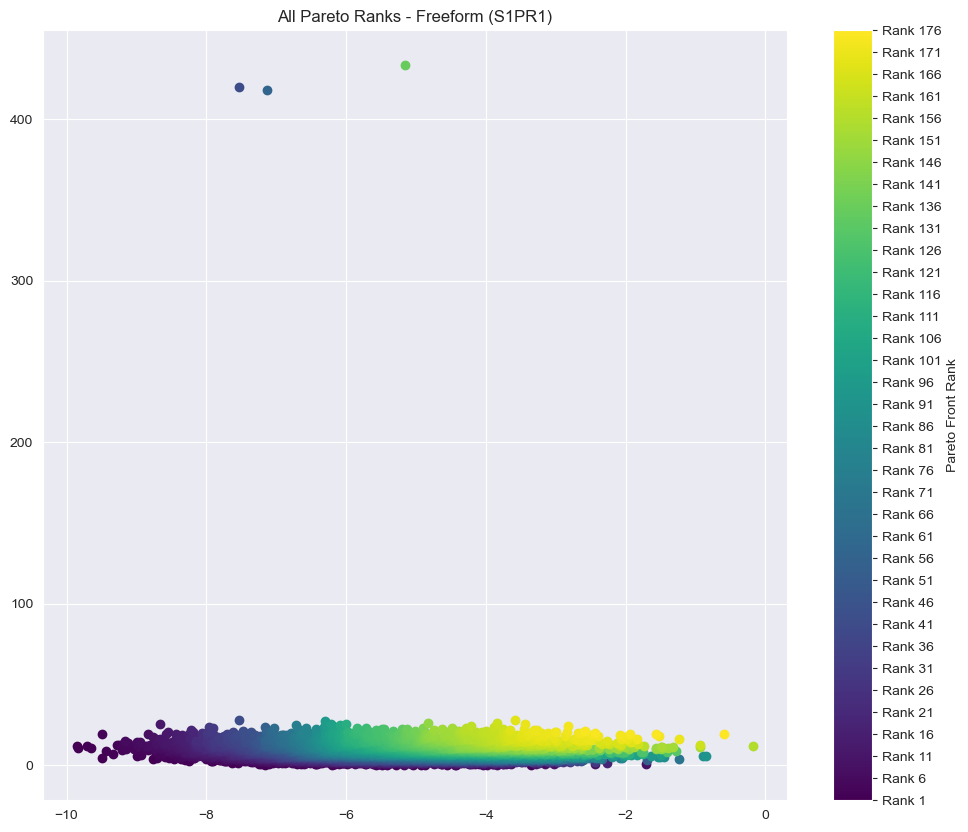

In [372]:
# Create a new figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# Normalize color gradient based on num_ranks, be careful how it is defined in the code
num_ranks = df_copy["ParetoRank"].nunique()
norm = plt.cm.colors.Normalize(vmin=0, vmax=num_ranks - 1)

# Set the title
ax.set_title(f"All Pareto Ranks - Freeform ({title_suffix})")

# Use the axes for the scatter plots
ax.scatter(
    df_copy["r_i_docking_score"],
    df_copy["Strain (kcal/mol)"],
    color="lightgrey",
    label="Baseline Data",
    alpha=0.5,
)

for i in range(1, num_ranks + 1):
    rank_data = df_copy[df_copy["ParetoRank"] == i]
    ax.scatter(
        rank_data["r_i_docking_score"],
        rank_data["Strain (kcal/mol)"],
        color=colormap(norm(i - 1)),
        label=f"Rank {i}",
    )

# Use the axes for the colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
# Reduce the number of ticks on the colorbar
cbar = fig.colorbar(sm, ax=ax, ticks=np.linspace(0, num_ranks - 1, num_ranks // 5))
cbar.ax.set_yticklabels([f"Rank {i*5+1}" for i in range(num_ranks // 5)])
cbar.set_label("Pareto Front Rank")

plt.grid(True)
plt.show()



In [283]:
print("Indices of Rank 1, Pareto Front:")
print(total_pareto_ranks_indices[:][0])

print("Updated Dataframe with Pareto Ranks:")
display(
    df_copy[df_copy["ParetoRank"] == 1][
        ["Molecule_Name", "ParetoRank", "r_i_docking_score", "Strain (kcal/mol)", "Activity"]
    ]
)

print("Original Dataframe:")
display(
    data.iloc[total_pareto_ranks_indices[:][0]][
        ["Molecule_Name", "r_i_docking_score", "Strain (kcal/mol)", "Activity"]
    ]
)



Indices of Rank 1, Pareto Front:
[   0    1    3    5   35  115  136  271  283  493  938 1102 5024 6033
 6266]
Updated Dataframe with Pareto Ranks:


,Molecule_Name,ParetoRank,r_i_docking_score,Strain (kcal/mol),Activity
1,C49722056_Isomer1,1.0,-9.85344,11.74,0
2,C04317377_Isomer1,1.0,-9.83913,10.98,0
4,C23663588_Isomer1,1.0,-9.65606,10.82,0
6,C40564286_Isomer1,1.0,-9.48587,4.60,0
36,ML056-3V2Y_Isomer2,1.0,-8.75918,3.87,1
116,C71418418_Isomer1,1.0,-8.30642,3.03,0
137,C13007425_Isomer1,1.0,-8.24383,3.01,0
272,C09377144_Isomer1,1.0,-7.93787,2.93,0
284,C06963478_Isomer1,1.0,-7.91593,2.43,0
494,C71738871_Isomer1,1.0,-7.62641,1.46,0


Original Dataframe:


,Molecule_Name,r_i_docking_score,Strain (kcal/mol),Activity
1,C49722056_Isomer1,-9.85344,11.74,0
2,C04317377_Isomer1,-9.83913,10.98,0
4,C23663588_Isomer1,-9.65606,10.82,0
6,C40564286_Isomer1,-9.48587,4.60,0
36,ML056-3V2Y_Isomer2,-8.75918,3.87,1
116,C71418418_Isomer1,-8.30642,3.03,0
137,C13007425_Isomer1,-8.24383,3.01,0
272,C09377144_Isomer1,-7.93787,2.93,0
284,C06963478_Isomer1,-7.91593,2.43,0
494,C71738871_Isomer1,-7.62641,1.46,0


  Ranks appear to be updated correctly, plot matches and data matches in df.

  Now we need to get enrichment metrics as well as save them to file.

  For Enrichment: We sort by pareto rank, but this metric doesn't really make sense in this context.

  For ROC, we use Rank as our score. Let's do this first.

Delta LogAUC (x10): -2.60


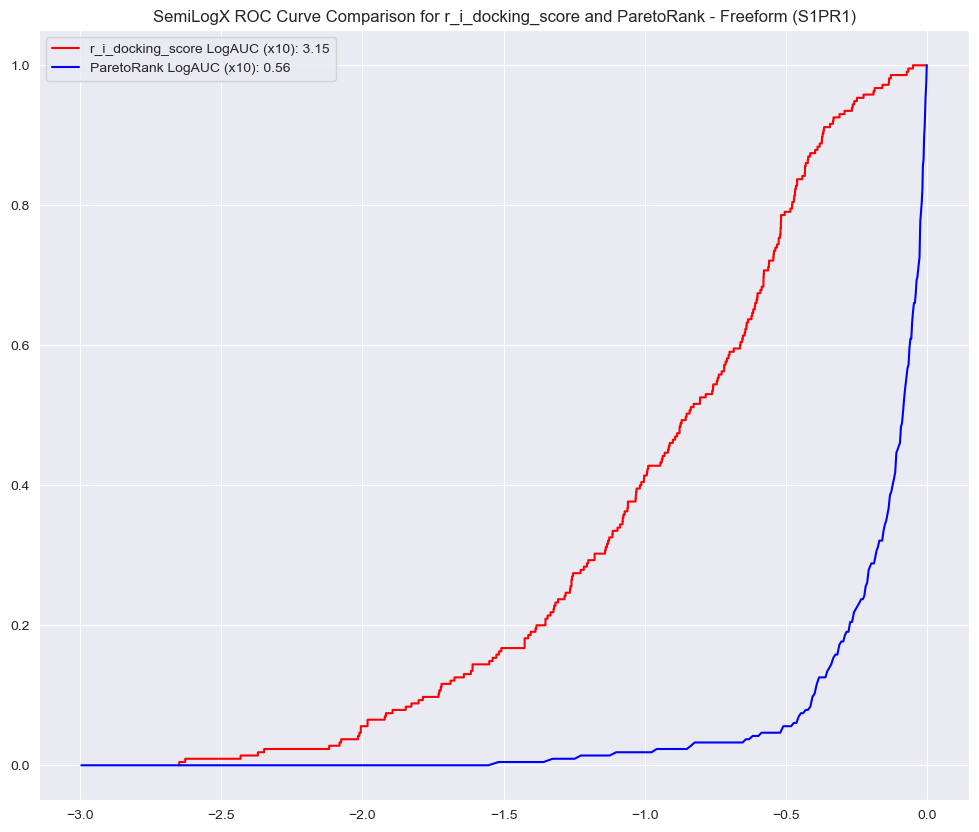

In [373]:
def plot_pareto_rank_semi_log_roc(df, a=1e-3, ax=None):
    # Baseline scores
    y_scores_baseline = -df["r_i_docking_score"]
    fpr_baseline, tpr_baseline, _ = roc_curve(df["Activity"], y_scores_baseline)
    valid_indices_baseline = np.where(fpr_baseline >= a)
    log_fpr_valid_baseline = np.log10(fpr_baseline[valid_indices_baseline])
    log_auc_baseline = (
        auc(log_fpr_valid_baseline, tpr_baseline[valid_indices_baseline]) / -np.log10(a)
    ) * 10
    ax.plot(
        log_fpr_valid_baseline,
        tpr_baseline[valid_indices_baseline],
        label=f"r_i_docking_score LogAUC (x10): {log_auc_baseline:.2f}",
        color="red",
    )

    # New scores
    y_scores_new = df["ParetoRank"]
    fpr_new, tpr_new, _ = roc_curve(df["Activity"], y_scores_new)
    valid_indices_new = np.where(fpr_new >= a)
    log_fpr_valid_new = np.log10(fpr_new[valid_indices_new])
    log_auc_new = (
        auc(log_fpr_valid_new, tpr_new[valid_indices_new]) / -np.log10(a)
    ) * 10
    ax.plot(
        log_fpr_valid_new,
        tpr_new[valid_indices_new],
        label=f"ParetoRank LogAUC (x10): {log_auc_new:.2f}",
        color="blue",
    )

    deltaLogAUC = log_auc_new - log_auc_baseline
    print(f"Delta LogAUC (x10): {deltaLogAUC:.2f}")

    ax.legend()
    ax.set_title(
        f"SemiLogX ROC Curve Comparison for r_i_docking_score and ParetoRank - Freeform ({title_suffix})"
    )


fig, ax = plt.subplots(figsize=(12, 10))
plot_pareto_rank_semi_log_roc(df_copy, a=1e-3, ax=ax)
plt.show()



Delta ROC: -0.55


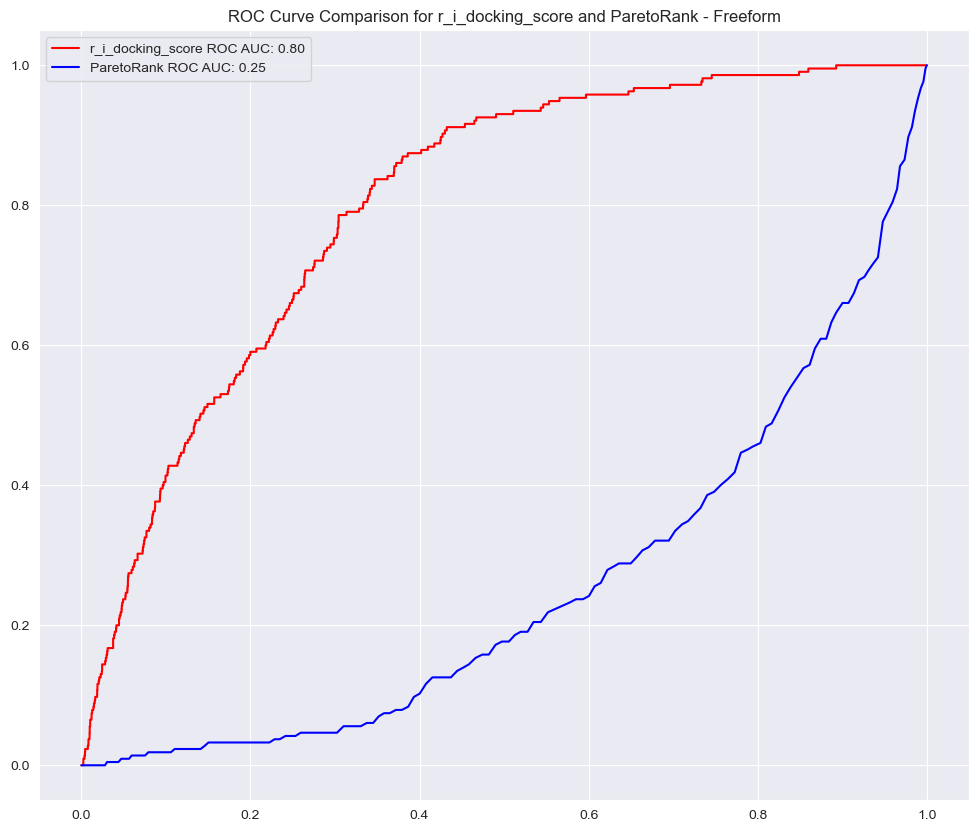

In [374]:
def plot_pareto_rank_roc(df, ax=None):
    # Baseline scores
    y_scores_baseline = -df["r_i_docking_score"]
    fpr_baseline, tpr_baseline, _ = roc_curve(df["Activity"], y_scores_baseline)
    roc_auc_baseline = auc(fpr_baseline, tpr_baseline)
    ax.plot(
        fpr_baseline,
        tpr_baseline,
        label=f"r_i_docking_score ROC AUC: {roc_auc_baseline:.2f}",
        color="red",
    )

    # New scores
    y_scores_new = df["ParetoRank"]
    fpr_new, tpr_new, _ = roc_curve(df["Activity"], y_scores_new)
    roc_auc_new = auc(fpr_new, tpr_new)
    ax.plot(
        fpr_new,
        tpr_new,
        label=f"ParetoRank ROC AUC: {roc_auc_new:.2f}",
        color="blue",
    )

    deltaROC = roc_auc_new - roc_auc_baseline
    print(f"Delta ROC: {deltaROC:.2f}")

    ax.legend()
    ax.set_title(f"ROC Curve Comparison for r_i_docking_score and ParetoRank - Freeform")


fig, ax = plt.subplots(figsize=(12, 10))
plot_pareto_rank_roc(df_copy, ax=ax)
plt.show()



In [375]:
def write_pareto_rank_metrics(df, a=1e-3, title_suffix=title_suffix):
    # initalize a dataframe to store pareto ranking metrics
    pareto_ranking_metrics = pd.DataFrame(
        columns=[
            "Protein",
            "Strain Energy Cutoff",
            "ROC_AUC",
            "Linear Log10 AUC (x10)",
            "deltaAUC",
            "Delta Linear Log10 AUC (x10)",
        ]
    )

    y_scores_baseline_log = -df["r_i_docking_score"]

    fpr_baseline_log, tpr_baseline_log, _ = roc_curve(
        df["Activity"], y_scores_baseline_log
    )

    valid_indices_baseline_log = np.where(fpr_baseline_log >= a)

    log_fpr_valid_baseline_log = np.log10(fpr_baseline_log[valid_indices_baseline_log])

    log_auc_baseline = (
        auc(log_fpr_valid_baseline_log, tpr_baseline_log[valid_indices_baseline_log])
        / -np.log10(a)
    ) * 10

    # New scores
    y_scores_new_log = df["ParetoRank"]

    fpr_new_log, tpr_new_log, _ = roc_curve(df["Activity"], y_scores_new_log)

    valid_indices_new_log = np.where(fpr_new_log >= a)

    log_fpr_valid_new = np.log10(fpr_new_log[valid_indices_new_log])

    log_auc_new = (
        auc(log_fpr_valid_new, tpr_new_log[valid_indices_new_log]) / -np.log10(a)
    ) * 10

    deltaLogAUC = log_auc_new - log_auc_baseline

    # Baseline scores
    y_scores_baseline = -df["r_i_docking_score"]
    fpr_baseline, tpr_baseline, _ = roc_curve(df["Activity"], y_scores_baseline)
    roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

    # New scores
    y_scores_new = df["ParetoRank"]
    fpr_new, tpr_new, _ = roc_curve(df["Activity"], y_scores_new)
    roc_auc_new = auc(fpr_new, tpr_new)

    deltaROC = roc_auc_new - roc_auc_baseline

    # Assign values to the dataframe
    new_row = {
        "Protein": title_suffix,
        "Strain Energy Cutoff": "ParetoRank",
        "ROC_AUC": roc_auc_new,
        "Linear Log10 AUC (x10)": log_auc_new,
        "deltaAUC": deltaROC,
        "Delta Linear Log10 AUC (x10)": deltaLogAUC,
    }

    pareto_ranking_metrics = pd.concat(
        [pareto_ranking_metrics, pd.DataFrame([new_row])], ignore_index=True
    )

    #make dir if it doesn't exist
    os.makedirs("./papermill/freeform_ParetoRankCSV", exist_ok=True)

    pareto_ranking_metrics.to_csv(
        f"./papermill/freeform_ParetoRankCSV/ParetoRanking_metrics_{title_suffix}.csv",
        index=False,
    )

    return pareto_ranking_metrics


write_pareto_rank_metrics(df_copy)


,Protein,Strain Energy Cutoff,ROC_AUC,Linear Log10 AUC (x10),deltaAUC,Delta Linear Log10 AUC (x10)
0,S1PR1,ParetoRank,0.253729,0.555182,-0.547007,-2.599044


In [289]:
pareto_ranking_metrics = write_pareto_rank_metrics(df_copy)
display(pareto_ranking_metrics)


,Protein,Strain Energy Cutoff,ROC_AUC,Linear Log10 AUC (x10),deltaAUC,Delta Linear Log10 AUC (x10)
0,S1PR1,ParetoRank,0.253729,0.555182,-0.547007,-2.599044
